# FRA503-DRL_HW2

**จัดทำโดย**

1. อนวัช อนุสุเรนทร์ 65340500056 
2. ชัญญาภัค ทรัพย์สวัสดิ์กุล 65340500067

## Part 1: Setting up Cart-Pole Agent

In [ ]:
#Set up
import torch
from collections import defaultdict
from enum import Enum
import numpy as np
import os
import json
import torch

class ControlType(Enum):
    MONTE_CARLO = 1
    TEMPORAL_DIFFERENCE = 2
    Q_LEARNING = 3
    DOUBLE_Q_LEARNING = 4

 ### 1. RL Base class

#### 1.1. Discretizes and scales the state based on observation weights.

In [ ]:
def discretize_state(self, obs: dict):
    #1. การกำหนดจำนวนค่าที่ใช้ในการแบ่งช่วง (Bins)
    pose_cart_bin = self.discretize_state_weight[0]
    pose_pole_bin = self.discretize_state_weight[1]
    vel_cart_bin = self.discretize_state_weight[2]
    vel_pole_bin = self.discretize_state_weight[3]
       
    # 2. การกำหนด Boundaries ของค่าต่างๆ*
    pose_cart_bound = 3
    pose_pole_bound = float(np.deg2rad(24.0))
    vel_cart_bound = 15
    vel_pole_bound = 15

    #3. การดึงข้อมูลจาก Observation
    pose_cart_raw, pose_pole_raw , vel_cart_raw , vel_pole_raw = obs['policy'][0, 0] , obs['policy'][0, 1] , obs['policy'][0, 2] , obs['policy'][0, 3]
    
    #4. การคลิปค่าพิกัดให้ไม่เกิน Boundaries
    pose_cart_clip = torch.clip(pose_cart_raw , -pose_cart_bound ,pose_cart_bound)
    pose_pole_clip = torch.clip(pose_pole_raw , -pose_pole_bound ,pose_pole_bound)
    vel_cart_clip = torch.clip(vel_cart_raw , -vel_cart_bound ,vel_cart_bound)
    vel_pole_clip = torch.clip(vel_pole_raw , -vel_pole_bound ,vel_pole_bound)
    device = pose_cart_clip.device

    # 5. สร้าง Grid สำหรับค่าที่ถูก Clip
    pose_cart_grid = torch.linspace(-pose_cart_bound , pose_cart_bound , pose_cart_bin , device=device)
    pose_pole_grid = torch.linspace(-pose_pole_bound , pose_pole_bound , pose_pole_bin , device=device)
    vel_cart_grid = torch.linspace(-vel_cart_bound , vel_cart_bound , vel_cart_bin , device=device)
    vel_pole_grid = torch.linspace(-vel_pole_bound , vel_pole_bound , vel_pole_bin , device=device)

    # 6. แปลงค่า Continuous เป็น Discrete
    pose_cart_dig = torch.bucketize(pose_cart_clip,pose_cart_grid)
    pose_pole_dig = torch.bucketize(pose_pole_clip,pose_pole_grid)
    vel_cart_dig = torch.bucketize(vel_cart_clip,vel_cart_grid)
    vel_pose_dig = torch.bucketize(vel_pole_clip,vel_pole_grid)

    return ( int(pose_cart_dig), int(pose_pole_dig), int(vel_cart_dig),  int(vel_pose_dig))


**อธิบายหลักการของโค้ด**

ฟังก์ชัน discretize_state มีหน้าที่ในการแปลงค่าจาก observation ที่เป็นค่า continuous ให้อยู่ในรูปแบบของ ค่า discrete หรือ index ซึ่งสามารถนำไปใช้งานกับ Q-table ได้

**ลำดับการทำงาน**
1.กำหนดจำนวนช่วง (bins)

กำหนดจำนวนระดับ (หรือ resolution) สำหรับแต่ละมิติของสถานะ เช่น ตำแหน่งรถ, มุมเสา, ความเร็ว

2.กำหนดขอบเขตของค่าที่ยอมรับได้ (boundaries)

ระบุค่าต่ำสุดและสูงสุดที่เราจะใช้ ซึ่งอ้างอิงจากไฟล์ "CartPole_4.2.0\exts\CartPole\CartPole\tasks\cartpole\stabilize_cartpole_env_cfg.py" เช่น
- ตำแหน่งรถไม่เกิน ±3
- มุมเสาไม่เกิน ±24 องศา (แปลงเป็นเรเดียน)

3.ดึงค่าจาก observation ที่รับมาจาก environment

ได้แก่ตำแหน่งและความเร็วของรถ + มุมและความเร็วของเสา

4.คลิป (clip) ตัดค่าที่เกินขอบเขต เพื่อให้ไม่มีค่าใดเกินขอบเขตที่เราสนใจและป้องกันไม่ให้เกิด index error

5.สร้าง grid (ช่วงของค่า)

ใช้ torch.linspace() เพื่อแบ่งช่วงค่าจากขอบล่างถึงขอบบน เป็นจำนวน bins ที่กำหนดไว้

6.แปลงค่าต่อเนื่องให้เป็นค่า discrete

ใช้ torch.bucketize() เพื่อหาว่าแต่ละค่าที่ถูก clip ตกอยู่ในช่วงไหนของ grid → ได้ผลลัพธ์เป็น index เป็น Discrete

#### 1.2.Select an action using an epsilon-greedy policy

In [ ]:
def get_discretize_action(self, obs_dis) -> int:
    if self.control_type == ControlType.DOUBLE_Q_LEARNING:
        #1.สำรวจ (exploration) เลือก action แบบสุ่ม ด้วยความน่าจะเป็น epsilon
        if torch.rand(1).item() < self.epsilon:
            return torch.randint(0, self.num_of_action, (1,)).item()
        
        #2.ใช้ค่าจาก Q-table ทั้งสองชุด (Double Q-Learning) เพื่อเลือก action
        else:
            qa_numpy = np.array(self.qa_values[obs_dis], dtype=np.float32)
            qb_numpy = np.array(self.qb_values[obs_dis], dtype=np.float32)

            #3.แปลงเป็น PyTorch tensor
            qa_tensor = torch.from_numpy(qa_numpy)
            qb_tensor = torch.from_numpy(qb_numpy)

            #4.หาค่า action ที่ดีที่สุดจากแต่ละ Q-table
            action_from_q1 = torch.argmax(qa_tensor).item()
            action_from_q2 = torch.argmax(qb_tensor).item()

            #5.เลือก action ที่มี Q-value สูงกว่าระหว่าง Q1 และ Q2
            best_action = action_from_q1 if qa_tensor[action_from_q1] >= qb_tensor[action_from_q2] else action_from_q2

            #6.ตรวจสอบให้แน่ใจว่า index อยู่ในช่วงที่ถูกต้อง
            action_idx = max(0, min(best_action, self.num_of_action - 1))
            return int(action_idx)

    else:
        #7.Q-Learning ปกติ (หรือ SARSA) ด้วยนโยบาย epsilon-greedy
        if torch.rand(1).item() < self.epsilon:
            return torch.randint(0, self.num_of_action, (1,)).item()  # สำรวจ (explore)
        else:
            #8.แปลง q_values เป็น tensor ก่อนหา argmax
            self.q_values[obs_dis] = torch.tensor(self.q_values[obs_dis], dtype=torch.float32)
            return int(torch.argmax(self.q_values[obs_dis]).item())  # ใช้ความรู้เดิม (exploit)


**อธิบายหลักการของโค้ด**

ฟังชั่น get_discretize_action เลือก action index ที่ดีที่สุดจาก Q-table (หรือสุ่ม) ด้วย epsilon-greedy
- ถ้า epsilon สูง → มีโอกาสเลือก action แบบสุ่ม (exploration)

- ถ้า epsilon ต่ำ → จะเลือก action ที่ดีที่สุดจาก Q-table (exploitation)

ในกรณี Double Q-Learning จะใช้ Q-table สองชุดในการช่วยกันตัดสินใจเพื่อหลีกเลี่ยง overestimation 

#### 1.3.Maps a discrete action in range [0, n]

In [ ]:
def mapping_action(self, action):
    action_min, action_max = self.action_range
    action_continuous = action_min + (action / (self.num_of_action - 1)) * (action_max - action_min)
    return torch.tensor(action_continuous, dtype=torch.float32)

**อธิบายหลักการของโค้ด**

ฟังก์ชัน mapping_action ใช้สำหรับแปลงค่าของ action index ซึ่งเป็นค่า discrete (เช่น 0, 1, 2, ...) ให้กลายเป็น continuous value ที่สามารถนำไปใช้กับ environment ได้จริง โดย continuous value ที่ได้จะกระจายอยู่ในช่วงที่กำหนดไว้ระหว่าง action_min ถึง action_max ตามจำนวน action ที่มีอยู่ (num_of_action)

**ตัวอย่าง**
action_range = (-1.0, 1.0)
num_of_action = 5
(เริ่มที่ 0 จบที่ 4)
- ถ้า action = 0 → ได้ -1.0
- ถ้า action = 2 → ได้  0.0
- ถ้า action = 4 → ได้  1.0

#### 1.4.Get action based on epsilon-greedy policy

In [ ]:
def get_action(self, obs) -> torch.Tensor:
    #1.แปลง observation ที่ Continuous ให้เป็น discrete
    obs_dis = self.discretize_state(obs)
    #2. เลือก action index ที่ควรทำใน state นั้น
    action_idx = self.get_discretize_action(obs_dis)
    #3. แปลงจาก action index เป็น action จริง
    action_tensor = self.mapping_action(action_idx)
    #4. เพิ่มมิติให้กับ tensor (จาก 1D → 3D) เพื่อให้ตรงกับ input shape ของ environment
    return action_tensor.unsqueeze(0).unsqueeze(0), action_idx 

#### 1.5. Decay epsilon value to reduce exploration over time

ทำการ Decay Epsilon แบบ linear อิงตาม Episode สูงสุดที่ใส่ในไฟล์ train

In [ ]:
def decay_epsilon(self, total_episodes ):
    #1. คำนวณอัตราการลดของ epsilon ต่อ 1 episode
    epsilon_decrease = (1.0 - self.final_epsilon) / total_episodes 
    # 2. ลดค่า epsilon และจำกัดไม่ให้ต่ำกว่า final_epsilon
    self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decrease)

#### 1.6. Save the model parameters to a JSON file

In [ ]:
def save_q_value(self, path, filename):
    # 1. แปลง tuple keys เป็น string เนื่องจาก JSON ไม่รองรับการเก็บ tuple
    try:
        q_values_str_keys = {str(k): v.tolist() for k, v in self.q_values.items()}
    except:
        q_values_str_keys = {str(k): v for k, v in self.q_values.items()}
    # 2. ถ้าเป็น Monte Carlo ให้แปลง n_values เป็น string keys และ list
    if self.control_type == ControlType.MONTE_CARLO:
        try:
            n_values_str_keys = {str(k): v.tolist() for k, v in self.n_values.items()}
        except:
            n_values_str_keys = {str(k): v for k, v in self.n_values.items()}
    # 3. เตรียมข้อมูลโมเดลที่จะบันทึก (Monte carlo ต้องบันทึก n-value เพิ่มด้วย)
    if self.control_type == ControlType.MONTE_CARLO:
        model_params = {
            'q_values': q_values_str_keys,
            'n_values': n_values_str_keys
        }
    else:
        model_params = {
            'q_values': q_values_str_keys,
         }
    # 4. สร้าง path สำหรับไฟล์ที่ต้องการบันทึก
    full_path = os.path.join(path, filename)
    # 5. บันทึกข้อมูลโมเดลลงในไฟล์ JSON
    with open(full_path, 'w') as f:
        json.dump(model_params, f)

#### 1.7.Load model parameters from a JSON file

In [ ]:
def load_model(self, path, filename):
    #1.สร้าง path สำหรับไฟล์ที่ต้องการโหลด
    full_path = os.path.join(path, filename)  
    #2.เปิดไฟล์และโหลดข้อมูลจาก JSON      
    with open(full_path, 'r') as file:
        data = json.load(file)
        data_q_values = data['q_values']
        #3.แปลงค่าจาก string เป็น Tuple และเก็บลงใน q_values
        for state, action_values in data_q_values.items():
            state = state.replace('(', '')
            state = state.replace(')', '')
            tuple_state = tuple(map(float, state.split(', ')))
            self.q_values[tuple_state] = action_values.copy()
            #กรณีของ DOUBLE_Q_LEARNING ต้องเก็บ q-value 2 table
            if self.control_type == ControlType.DOUBLE_Q_LEARNING:
                self.qa_values[tuple_state] = action_values.copy()
                self.qb_values[tuple_state] = action_values.copy()
        #กรณีของ Monte carlo ต้องเก็บ n-value ด้วย
        if self.control_type == ControlType.MONTE_CARLO:
            data_n_values = data['n_values']
            for state, n_values in data_n_values.items():
                state = state.replace('(', '')
                state = state.replace(')', '')
                tuple_state = tuple(map(float, state.split(', ')))
                self.n_values[tuple_state] = n_values.copy()
        return self.q_values

**อธิบายหลักการของโค้ด**

ฟังก์ชัน load_model ใช้สำหรับโหลดโมเดลที่ถูกฝึกแล้วจากไฟล์ JSON ซึ่งเก็บข้อมูล Q-values และข้อมูลที่เกี่ยวข้องกับการ Train Agent ฟังก์ชัน load_model จะดึงข้อมูล Q-values สำหรับแต่ละ state-action pair จากไฟล์และแปลง state ที่เก็บเป็น String ที่อยู่ในรูปแบบของ tuple(เช่น "(1.0, 2.0)") ให้เป็น real tuple ที่มีค่าเป็น float และเก็บค่าของ action ที่เกี่ยวข้องใน q_values ของ Agent

- สำหรับ Double Q-learning (DQ) ฟังก์ชันจะโหลด Q-values ทั้งจาก Q_A และ Q_B, ซึ่งเป็นการใช้ สอง Q-tables แยกกันเพื่อเลือก action ที่ดีที่สุดและอัปเดต Q-values โดยลดปัญหา overestimation bias.

- สำหรับ Monte Carlo (MC) ฟังก์ชันจะโหลด n_values ซึ่งใช้เก็บการนับจำนวนครั้งที่ state-action pair ถูก Agent เยี่ยมชม(ถูกเลือกใช้จริง)ระหว่างการฝึก และใช้ข้อมูลนี้ในการคำนวณค่าเฉลี่ยของ Q-values อย่างถูกต้อง เพื่ออัปเดต Q-values ที่ stable และ unbiased

### 2. Algorithm

#### 2.1. Monte Carlo

**แนวคิด**

Monte Carlo เป็นวิธีการเรียนรู้เสริมกำลัง (Reinforcement Learning - RL) ที่อิงกับการใช้ค่า **ประสบการณ์ทั้งหมด(next state ถึง end)ของแต่ละตอน (episode)** เพื่ออัปเดตค่าประมาณของฟังก์ชันค่า (Value Function)

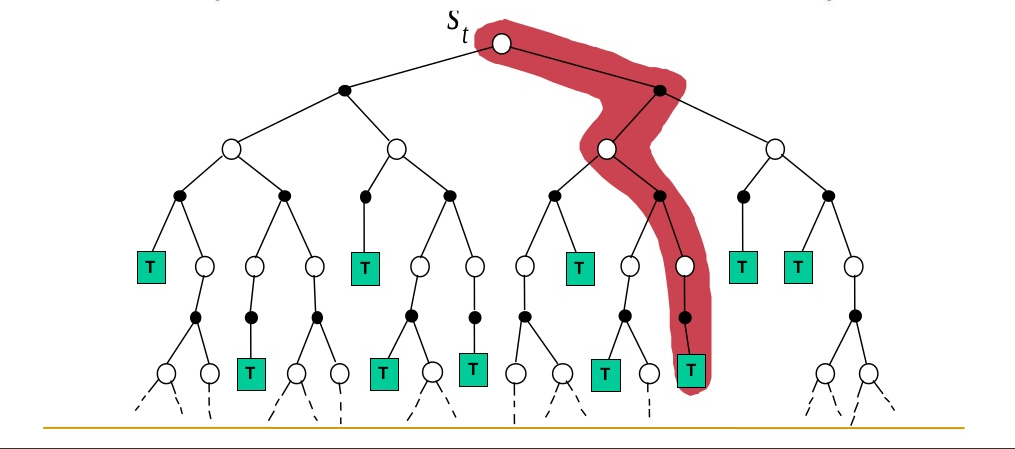

In [ ]:
def update(self):
    """
    Update Q-values using Monte Carlo.
    This method applies the Monte Carlo update rule to improve policy decisions by updating the Q-table.
    """
    return_sum = 0 

    obs_hist_list = [tuple(obs.cpu().numpy()) if isinstance(obs, torch.Tensor) else tuple(obs) for obs in self.obs_hist]
    # update First occur
    for t in reversed(range(len(self.obs_hist))):
        state = self.obs_hist[t]
        action = self.action_hist[t]
        reward = self.reward_hist[t]
        if isinstance(state, dict):
            state = tuple(state.values())  
        if isinstance(state, torch.Tensor):
            state = tuple(state.cpu().numpy()) 
            return_sum = self.discount_factor * return_sum + reward  # Compute return     
        if state not in obs_hist_list[:t]:  # First-visit MC update
            self.n_values[state][action] += 1
            self.q_values[state][action] = ((self.q_values[state][action] * (self.n_values[state][action])) + return_sum) / (self.n_values[state][action] + 1)

**อธิบายโค้ดแยกแต่ละส่วน**

**1. กำหนดโครงสร้างเริ่มต้น**

1. กำหนด return ตั้งต้น

        return_sum = 0

2. ย้อนลูปจาก timestep สุดท้ายไป timestep แรก เพราะต้องการคำนวณ return จากอนาคตมายังปัจจุบัน พร้อมทั้งดึงข้อมูลของ state, action, และ reward ใน timestep t จาก history ของ episode

        for t in reversed(range(len(self.obs_hist))):
                state = self.obs_hist[t]
                action = self.action_hist[t]
                reward = self.reward_hist[t]

**2. การคำนวณค่าผลตอบแทนสะสม (Return)**

ค่าผลตอบแทนสะสมถูกคำนวณย้อนกลับจากตอนจบของ episode
ใช้สูตร Discounted Return เพื่อลดค่าน้ำหนักของ reward ในอนาคต

        return_sum = self.discount_factor * return_sum + reward  


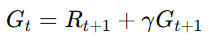   ----กระจายได้เป็น---> 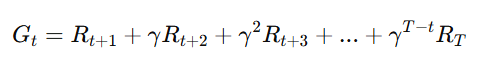
- G_𝑡 >> ค่าผลตอบแทนที่สะสม (Return) ใน timestep t
- 𝑅_𝑡 >> reward ที่ได้รับใน timestep t
- γ >> Discount Factor ที่ใช้ลดค่าของ reward ในอนาคตให้มีน้ำหนักน้อยลง

**3. First-Visit Monte Carlo Condition**

เช็คว่า state นี้ปรากฏเป็นครั้งแรกใน episode หรือไม่

        if state not in self.obs_hist[:t]:

ถ้าใช่
1. Update ค่าจำนวนครั้งที่ state-action นี้ถูกสำรวจ

        self.n_values[state][action] += 1
2. Update ค่า Q-value ของ (state, action)

        self.q_values[state][action] += (return_sum - self.q_values[state][action]) / self.n_values[state][action]


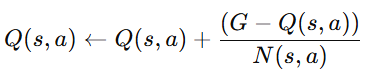

- Q(s,a) >> ค่าประมาณ Q-value ของ state-action ปัจจุบัน
- 𝐺(s,a) >> ค่าผลตอบแทนสะสม return_sum
- N(s,a) >> จำนวนครั้งที่ state-action (s, a) ถูกเข้าถึง

#### 2.2. SARSA class

**หลักการของ SARSA**

SARSA ใช้เพื่อปรับปรุงการตัดสินใจโดยการเรียนรู้จาก action ที่ Agent เลือกจริงๆ ในแต่ state  (ไม่ใช่เลือกแค่ action ที่ดีที่สุดในอนาคต)

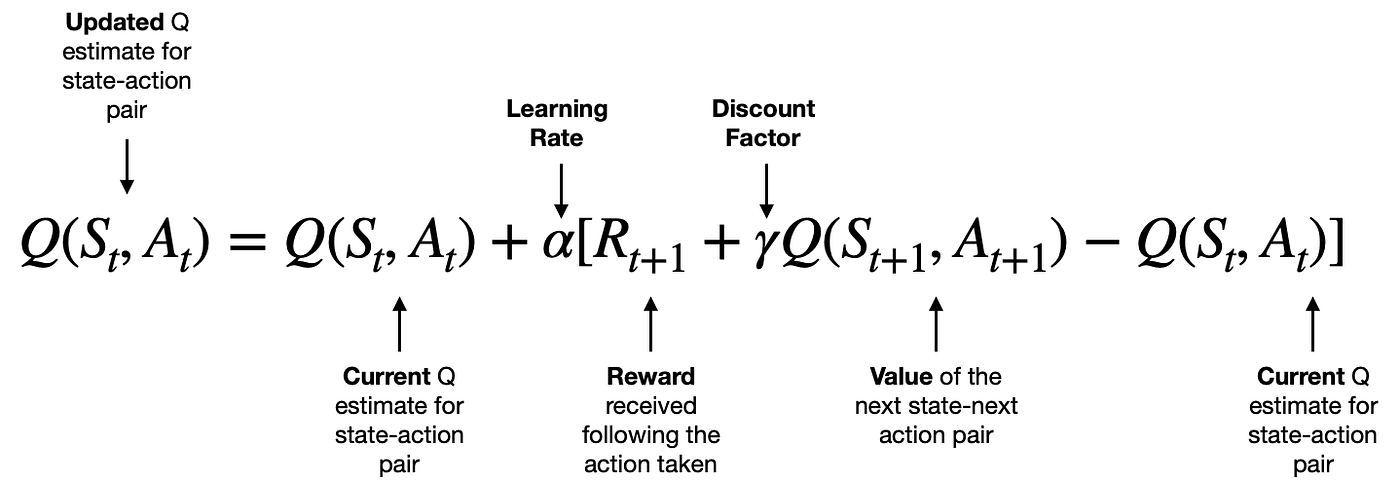

- State (S) >>  คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

- Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

- Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบัน ที่เวลา t

- Next State (S') >>  คือ State ที่ Agent ย้ายไปหลังจากทำ action

- Next Action (A') >> คือ action ที่ Agent ลือกใน state ถัดไป

In [ ]:
def update(self, state, action, reward, next_state, next_action):
        """
        Update Q-values using SARSA.

        This method applies the SARSA update rule to improve policy decisions by updating the Q-table.    
        """
        q_current = self.q_values[state][action]
        q_next = self.q_values[next_state][next_action] if next_state is not None else 0  
        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current) 

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การคำนวณ Q-value ปัจจุบัน**

        q_current = self.q_values[state][action]

q_current เป็น Q-value ของ action ใน state ปัจจุบัน ซึ่งค่า Q-value นี้จะเก็บการประเมินว่า action ใน state นี้ดีแค่ไหนในแง่ของ reward ที่ Agent คาดว่าจะได้รับ

**2. การคำนวณ Q-value ของ next sate**

        q_next = self.q_values[next_state][next_action] if next_state is not None else 0

q_next คือ Q-value ของ next_state และ next_action ถ้าหาก next_state ไม่ใช่ None แต่ถ้า next_state คือ None หมายถึงเราอยู่ในสถานะสุดท้ายแล้ว ค่าของ q_next จะเป็น 0

**3. การอัปเดต Q-value ด้วยกฎของ SARSA**

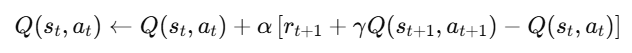

        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)
        

อัปเดต Q-value โดยใช้สูตรของ SARSA ซึ่งคำนวณจากค่าผิดพลาดระหว่างค่าที่คาดการณ์ (expected value) และค่าที่ได้รับจริง (real value) เพื่อปรับปรุง Q-value ให้ดีขึ้น


#### 2.3. Q-Learning Class

**หลักการของ Q-Learning**

Q-learning เป็น Off-Policy Reinforcement Learning วิธีที่ช่วยให้ตัวแทนเรียนรู้การเลือก action ที่ดีที่สุดในแต่ละ state โดยการอัปเดต Q-value ซึ่งคือค่าประเมินสำหรับการทำ action ใน state นั้นๆ โดยคำนึงถึง reward ที่ได้รับจากการทำ action และการเลือก action ที่ดีที่สุดใน state ถัดไป

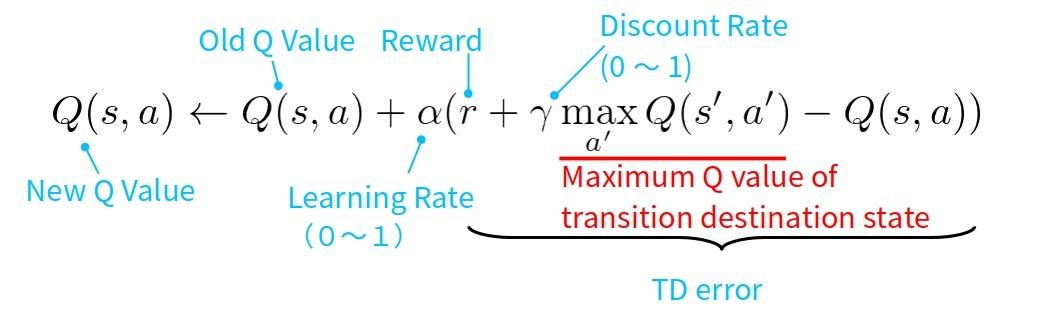

State (S) >> คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบัน ที่เวลา t

Next State (S') >> คือ State ที่ Agent ย้ายไปหลังจากทำ action

Max Action Q-value (max_a Q(s')) >> คือ ค่าของ action ที่ดีที่สุดใน state ถัดไป (เลือก action ที่ให้ Q-value สูงสุดใน state ถัดไป)

In [ ]:
def update(self, state, action, reward, next_state):
        """
        Update Q-values using Q-Learning.

        This method applies the Q-Learning update rule to improve policy decisions by updating the Q-table.
        """
        q_current = self.q_values[state][action] = self.q_values[state][action]
        q_next = 0 if next_state is None else np.max(self.q_values[next_state]) 
        
        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การคำนวณ Q-value ปัจจุบัน**

        q_current = self.q_values[state][action]

q_current เป็น Q-value ของ action ใน state ปัจจุบัน ซึ่งค่า Q-value นี้จะเก็บการประเมินว่า action ใน state นี้ดีแค่ไหนในแง่ของ reward ที่ Agent คาดว่าจะได้รับ

**2. การคำนวณ Q-value ที่ดีที่สุดของ next sate**

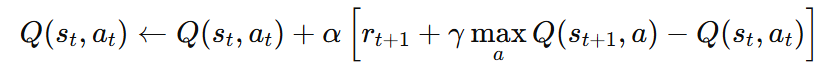

        q_next = 0 if next_state is None else np.max(self.q_values[next_state]) 

q_next คือ ค่าที่ดีที่สุดใน Q-table ของ next_state , ได้จากการใช้ np.max(self.q_values[next_state]) เพื่อเลือก action ที่ดีที่สุดใน state นั้น

**3. การอัปเดต Q-value ด้วยกฎของ Q-Learning**

        self.q_values[state][action] += self.lr * (reward + (self.discount_factor * q_next) - q_current)

อัปเดต Q-value โดยใช้ค่าที่ดีที่สุดใน Q-table ของ next_state ซึ่งคำนวณจากค่าผิดพลาดระหว่างค่าที่คาดการณ์ (expected value) และค่าที่ได้รับจริง (real value) เพื่อปรับปรุง Q-value ให้ดีขึ้น

#### 2.4. Double Q-Learning Class

**หลักการของ Double Q-learning**

Double Q-learning (DQ) คือการขยายจาก Q-learning ที่มีจุดประสงค์หลักเพื่อแก้ไขปัญหาของ overestimation bias ในการประเมิน Q-values ของการกระทำในแต่ละสถานะ (state-action values) โดยการใช้ สอง Q-tables (Q_A และ Q_B) แทนการใช้ Q-table เดียวเหมือนใน Q-learning ปกติ มีหลักการคิดคือ

**อัปเดต Q-value โดยใช้การเลือก action ที่ดีที่สุดจากหนึ่ง Q-table และใช้อีก Q-table ในการประเมิน Q-value ของ action ที่เลือก**


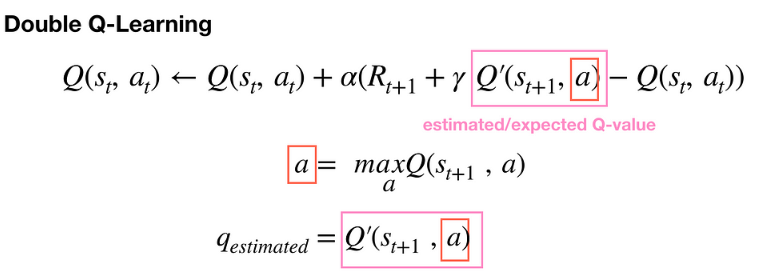

State (S) >> คือ State ปัจจุบันที่ Agent อยู่ในตอนนั้น

Action (A) >> คือ action ที่ Agent เลือกใน State ปัจจุบัน

Reward (R) >> คือ reward ที่ได้รับหลังจากทำ action ใน state ปัจจุบันที่เวลา t

Next State (S') >> คือ State ที่ Agent ย้ายไปหลังจากทำ action

Max Action Q-value (max_a Q(s')) >> คือ ค่าของ action ที่ดีที่สุดใน state ถัดไป (เลือก action ที่ให้ Q-value สูงสุดใน state ถัดไป) โดยใช้ Q_A หรือ Q_B เพื่อเลือก action ที่ดีที่สุดจากสอง Q-tables

In [ ]:
def update(self, state, action, reward, next_state):
    if next_state not in self.qa_values:
        self.qa_values[next_state] = np.zeros(self.num_of_action)
    if next_state not in self.qb_values:
        self.qb_values[next_state] = np.zeros(self.num_of_action)

    if np.random.rand() < 0.5:
        # Update Q_A using Q_B
        best_next_action = np.argmax(self.qa_values[next_state])
        q_next = 0 if next_state is None else self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qa_values[state][action])
    else:
        # Update Q_B using Q_A
        best_next_action = np.argmax(self.qb_values[next_state])
        q_next = 0 if next_state is None else self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qb_values[state][action])
        
    #อัปเดตค่า Q-Table 
    self.q_values[state] = (self.qa_values[state] + self.qb_values[state]) / 2

**อธิบายโค้ดแยกแต่ละส่วน**

**1. การตรวจสอบว่า next_state มีการบันทึก Q-values หรือไม่**

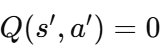

ถ้า next_state ยังไม่มีการบันทึก Q-value ใน Q-tables (ทั้ง Q_A และ Q_B), เราจะสร้างค่าเริ่มต้นเป็น 0 สำหรับ Q_A และ Q_B (จำนวน action ตามที่กำหนด) 

    if next_state not in self.qa_values:
        self.qa_values[next_state] = np.zeros(self.num_of_action)
    if next_state not in self.qb_values:
        self.qb_values[next_state] = np.zeros(self.num_of_action)

**2. การเลือกว่าจะอัปเดต Q_A หรือ Q_B**

    if np.random.rand() < 0.5:
        # Update Q_A using Q_B
        best_next_action = np.argmax(self.qa_values[next_state])
        q_next = self.qb_values[next_state][best_next_action]
        self.qa_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qa_values[state][action])
    else:
        # Update Q_B using Q_A
        best_next_action = np.argmax(self.qb_values[next_state])
        q_next = self.qa_values[next_state][best_next_action]
        self.qb_values[state][action] += self.lr * (reward + self.discount_factor * q_next - self.qb_values[state][action])

การใช้ np.random.rand() < 0.5 เพื่อสุ่มว่าจะอัปเดต Q_A หรือ Q_B


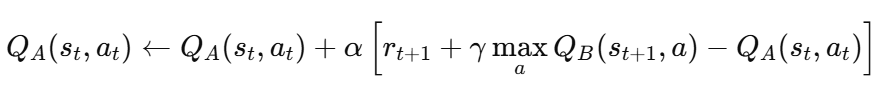


1. ถ้าเงื่อนไขเป็นจริง (เลือกอัปเดต Q_A):

- เลือก action ที่ดีที่สุดใน next_state จาก Q_A (best_next_action = np.argmax(self.qa_values[next_state]))

- นำ Q_B มาใช้ในการคำนวณ q_next ซึ่งเป็น Q-value ของ best_next_action ใน next_state ของ Q_B

- อัปเดต Q_A สำหรับ state และ action ปัจจุบัน โดยใช้ TD error ที่คำนวณจาก reward และ q_next


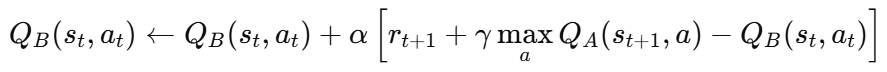


2. ถ้าไม่เป็นจริง (เลือกอัปเดต Q_B):

- เลือก action ที่ดีที่สุดใน next_state จาก Q_B (best_next_action = np.argmax(self.qb_values[next_state]))

- นำ Q_A มาใช้ในการคำนวณ q_next ซึ่งเป็น Q-value ของ best_next_action ใน next_state ของ Q_A

- อัปเดต Q_B สำหรับ state และ action ปัจจุบัน โดยใช้ TD error ที่คำนวณจาก reward และ q_next

**3. การอัปเดต Q-values โดยเฉลี่ยระหว่าง Q_A และ Q_B**

    self.q_values[state] = (self.qa_values[state] + self.qb_values[state]) / 2

คำนวณ Q-value สุดท้ายสำหรับ state ปัจจุบันโดยการเฉลี่ยค่า Q_A และ Q_B ที่อัปเดตแล้ว

## Part 2: Trainning & Playing to stabilize Cart-Pole Agent

###  1. implement the training loop in train script (in the "Can be modified")

#### 1.1. Monte Carlo

In [ ]:
# reset environment
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0

# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0

            agent.obs_hist = []
            agent.action_hist = []
            agent.reward_hist = []

            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)

                next_obs, reward, terminated, truncated, _ = env.step(action)

                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value

                agent.obs_hist.append(agent.discretize_state(obs))
                agent.action_hist.append(action_idx)
                agent.reward_hist.append(reward_value)

                count += 1
                    
                done = terminated or truncated
                obs = next_obs

            agent.update()  #edit here
            sum_reward += cumulative_reward
            sum_count += count

            if episode % 100 == 0:
                sum_reward = 0
                sum_count = 0        
                # Save MC agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                agent.save_q_value(full_path, q_value_file)
                    
            agent.decay_epsilon(n_episodes)
                   
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break 
    print("!!! Training is complete !!!")
    break

#### 1.2. SARSA

In [ ]:
# reset environment
obs, _ = env.reset()
print('obs :',obs)
timestep = 0
sum_reward = 0
sum_count = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
        for episode in tqdm(range(n_episodes),desc="Processing",leave=False,dynamic_ncols=True):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0
                
            while not done:
                state = agent.discretize_state(obs)
                # agent stepping
                action, action_idx = agent.get_action(obs) #bro
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action) #bro

                next_state = agent.discretize_state(next_obs)
                next_action_idx =agent.get_discretize_action(next_state)

                reward_value = reward.item()#bro
                terminated_value = terminated.item() #bro                  
                cumulative_reward += reward_value#bro
                    
                # editable agent update
                agent.update(state, action_idx, reward_value, next_state,  next_action_idx)  #edit here
                    
                count +=1
                    
                done = terminated or truncated#bro
                obs = next_obs#bro
                
                sum_count += count
                sum_reward += cumulative_reward

            if episode % 100 == 0:
                sum_reward = 0
                sum_count = 0 
                # Save SARSA agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                agent.save_q_value(full_path, q_value_file)
            agent.decay_epsilon(n_episodes)   
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break
    print("!!! Training is complete !!!")
    break

##### 3. Q-Learning

In [ ]:
# reset environment
    obs, _ = env.reset()
    timestep = 0
    sum_reward = 0
    sum_count = 0
    # simulate environment
    while simulation_app.is_running():
        # run everything in inference mode
        with torch.inference_mode():
            
            for episode in tqdm(range(n_episodes)):
                obs, _ = env.reset()
                done = False
                cumulative_reward = 0
                count = 0
                while not done:

                    state = agent.discretize_state(obs)
                    # agent stepping
                    action, action_idx = agent.get_action(obs)
                    # print('action',action)
                    # env stepping
                    next_obs, reward, terminated, truncated, _ = env.step(action)

                    next_state = agent.discretize_state(next_obs)

                    reward_value = reward.item()
                    terminated_value = terminated.item() 
                    cumulative_reward += reward_value
                    
                    # editable agent update
                    agent.update(state, action_idx, reward_value, next_state)  #edit here
                    
                    count += 1
                    run.log({"epsilon": agent.epsilon,
                            "Episode": episode})

                    done = terminated or truncated
                    obs = next_obs

                    # print('state :' , state, 'action_idx', action, 'reward :', reward_value,'Next state ',next_state)
                sum_count += count
                sum_reward += cumulative_reward
                if episode % 100 == 0:
                    print("avg_score: ", sum_reward / 100.0)
                    print(agent.epsilon)
                    run.log({"avg_count_per_ep":sum_count / 100.0,
                             "avg_reward":sum_reward / 100.0})
                    
                    sum_reward = 0
                    sum_count = 0
                    
                    # Save Q-Learning agent
                    q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                    full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                    agent.save_q_value(full_path, q_value_file)

                agent.decay_epsilon(n_episodes)
            
            
        if args_cli.video:
            timestep += 1
            # Exit the play loop after recording one video
            if timestep == args_cli.video_length:
                break
        
        print("!!! Training is complete !!!")

        break

##### 4. Double Q Learning

In [ ]:
# reset environment
obs, _ = env.reset()
timestep = 0
sum_reward = 0
sum_count = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
        for episode in tqdm(range(n_episodes)):
            obs, _ = env.reset()
            done = False
            cumulative_reward = 0
            count = 0

            while not done:

                state = agent.discretize_state(obs)
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)

                next_state = agent.discretize_state(next_obs)

                reward_value = reward.item()
                terminated_value = terminated.item() 
                cumulative_reward += reward_value
                    
                # editable agent update
                agent.update(state, action_idx, reward_value, next_state)  #edit here
                    
                count += 1
                done = terminated or truncated
                obs = next_obs
                
            sum_count += count
            sum_reward += cumulative_reward

            if episode % 100 == 0:
                sum_reward = 0
                sum_count = 0

                # Save DQ-Learning agent
                q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
                full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
                agent.save_q_value(full_path, q_value_file)

            agent.decay_epsilon(n_episodes)       
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break 
    print("!!! Training is complete !!!")
    break

### 2. Stabilizing Cart-Pole Experiment

#### 2.1.ทดลองปรับ hyperparameters ที่เกี่ยวข้องกับการเรียนรู้ของ Agent

**Learning Objective**

1. Understand how a reinforcement learning agent learns (i.e., evaluates and improves its policy) in an environment where the true dynamic model is unknown.

2. Gain insight into different reinforcement learning algorithms, including Monte Carlo methods, the SARSA algorithm, Q-learning, and Double Q-learning. Analyze their strengths and weaknesses.

**hyperparameters ที่จะปรับ**
1. Learning rate (learing_rate) : 0.01 0.1 0.3 0.9
2. Discount Factor (discount): 0.1 0.5 0.9
3. Epsilon (epsilon_decay, start_epsilon, final_epsilon)
    - start_epsilon
    - epsilon_decay
    - final_epsilon


**ตัวแปรควบคุม**
- num_of_action = 11

- action_range = [-16.0, 16.0]

- discretize_state_weight = [5, 11, 3, 3]

- n_episodes = num_of_action * discretize_state_weight[0] * discretize_state_weight[1] * discretize_state_weight[2] * discretize_state_weight[3]*2 

**episodes = 10890 เสมอ

##### 1.Learning rate 

**Monte carlo**
- Learning rate 0.1 (Discount 0.5)

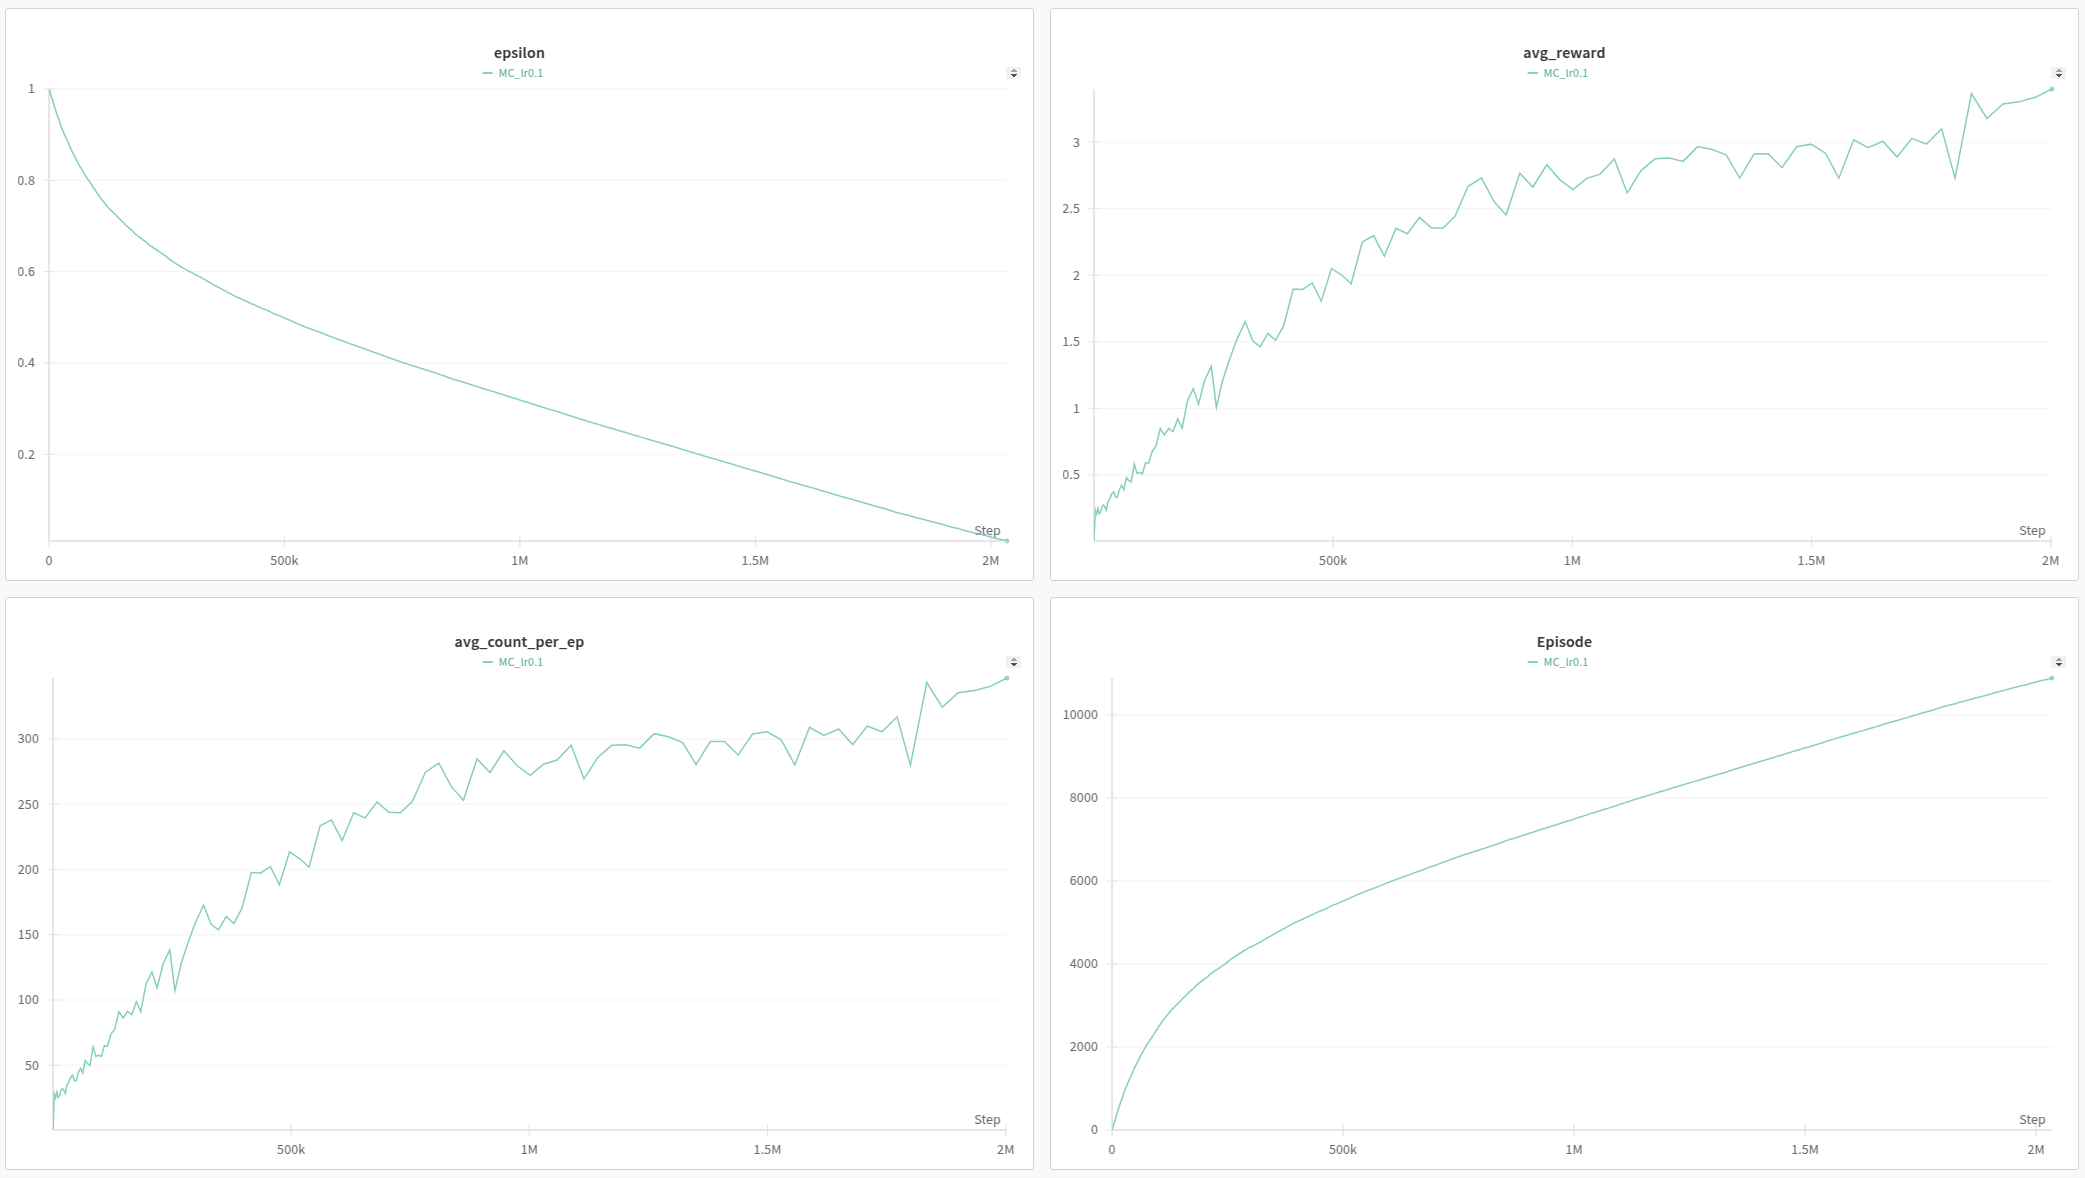

- Learning rate 0.3 (Discount 0.5)

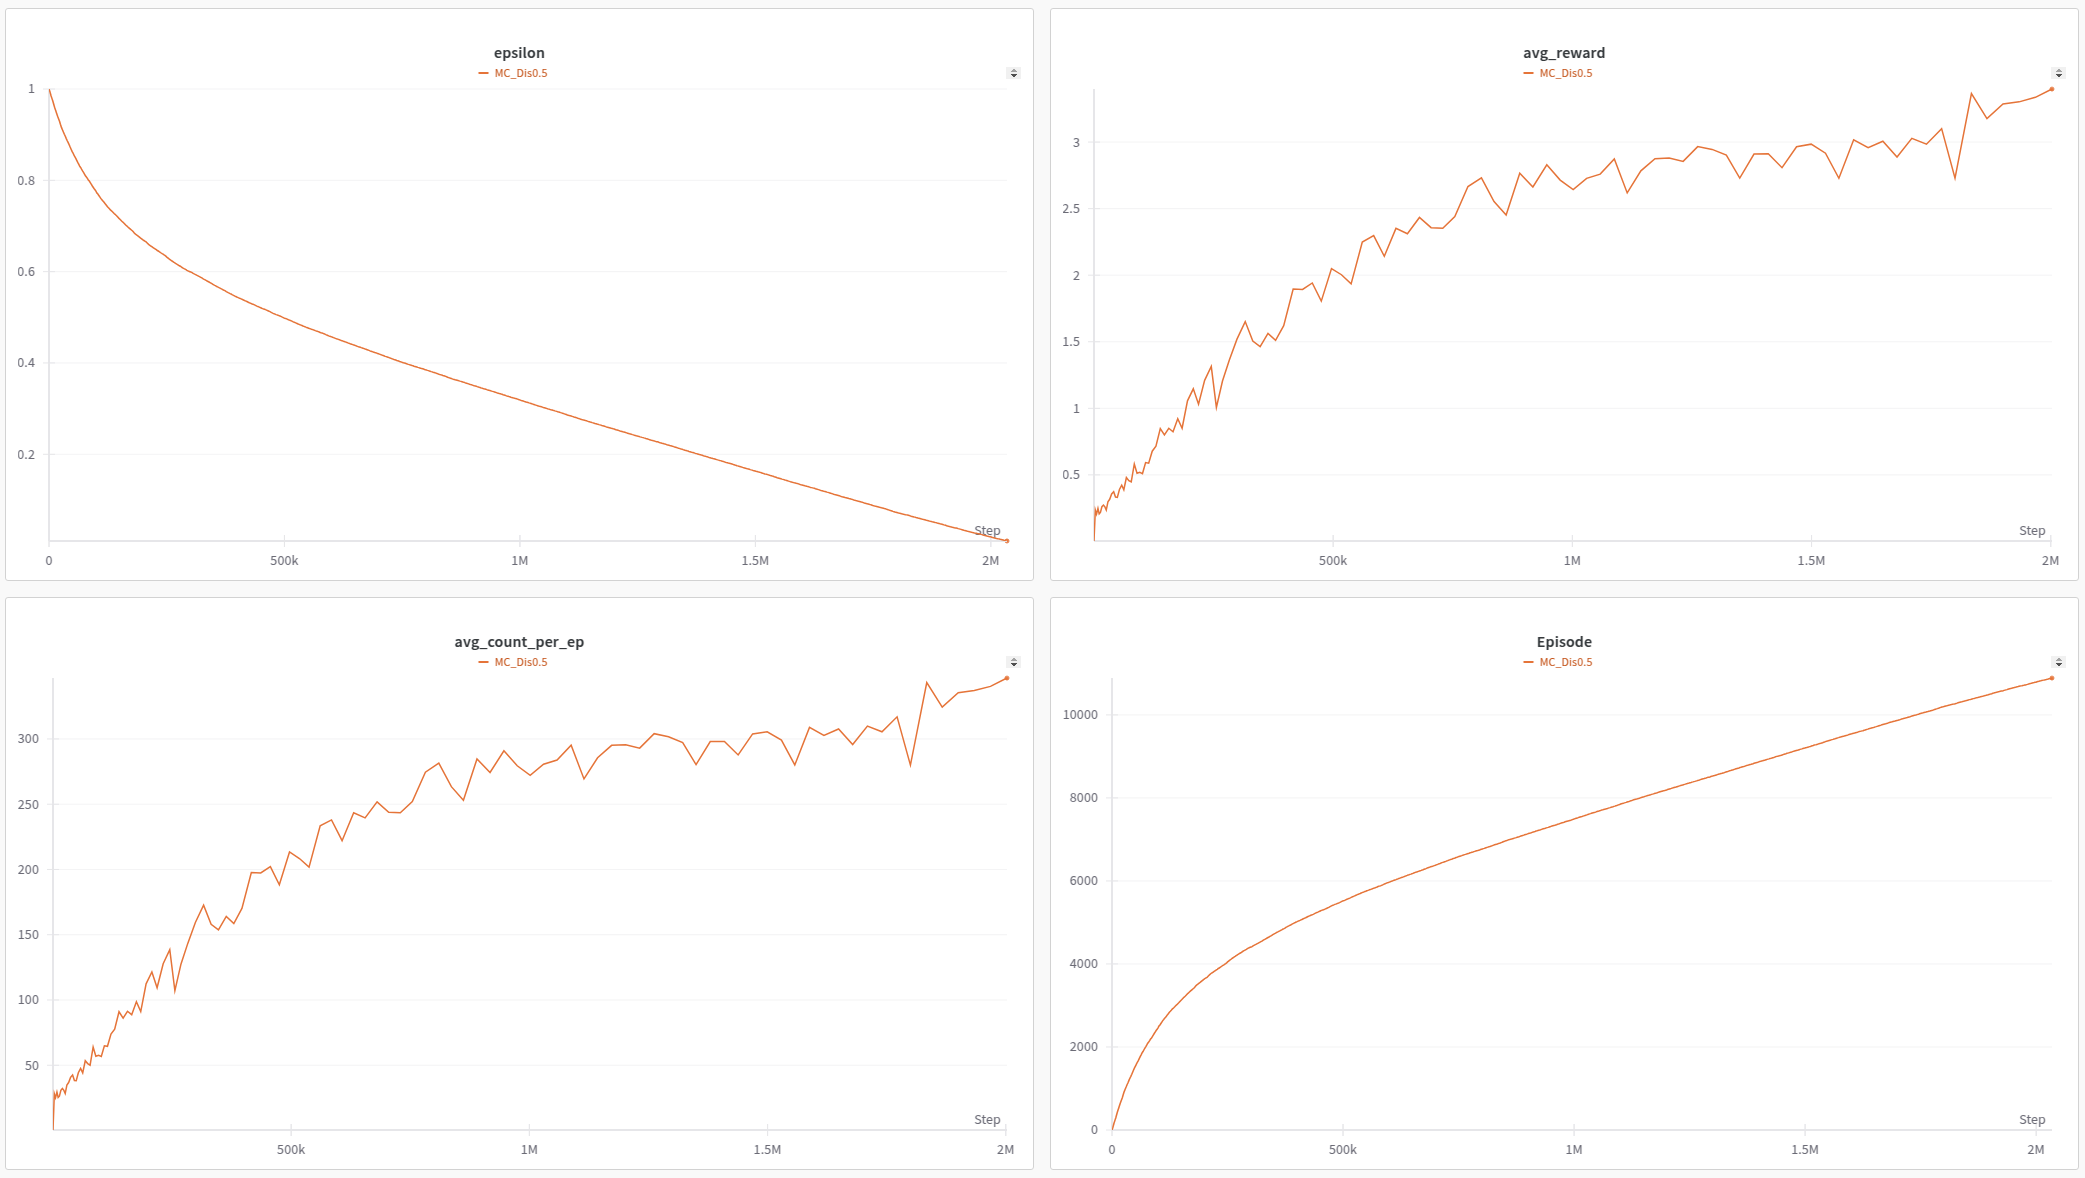

- Learning rate 0.9 (Discount 0.5)

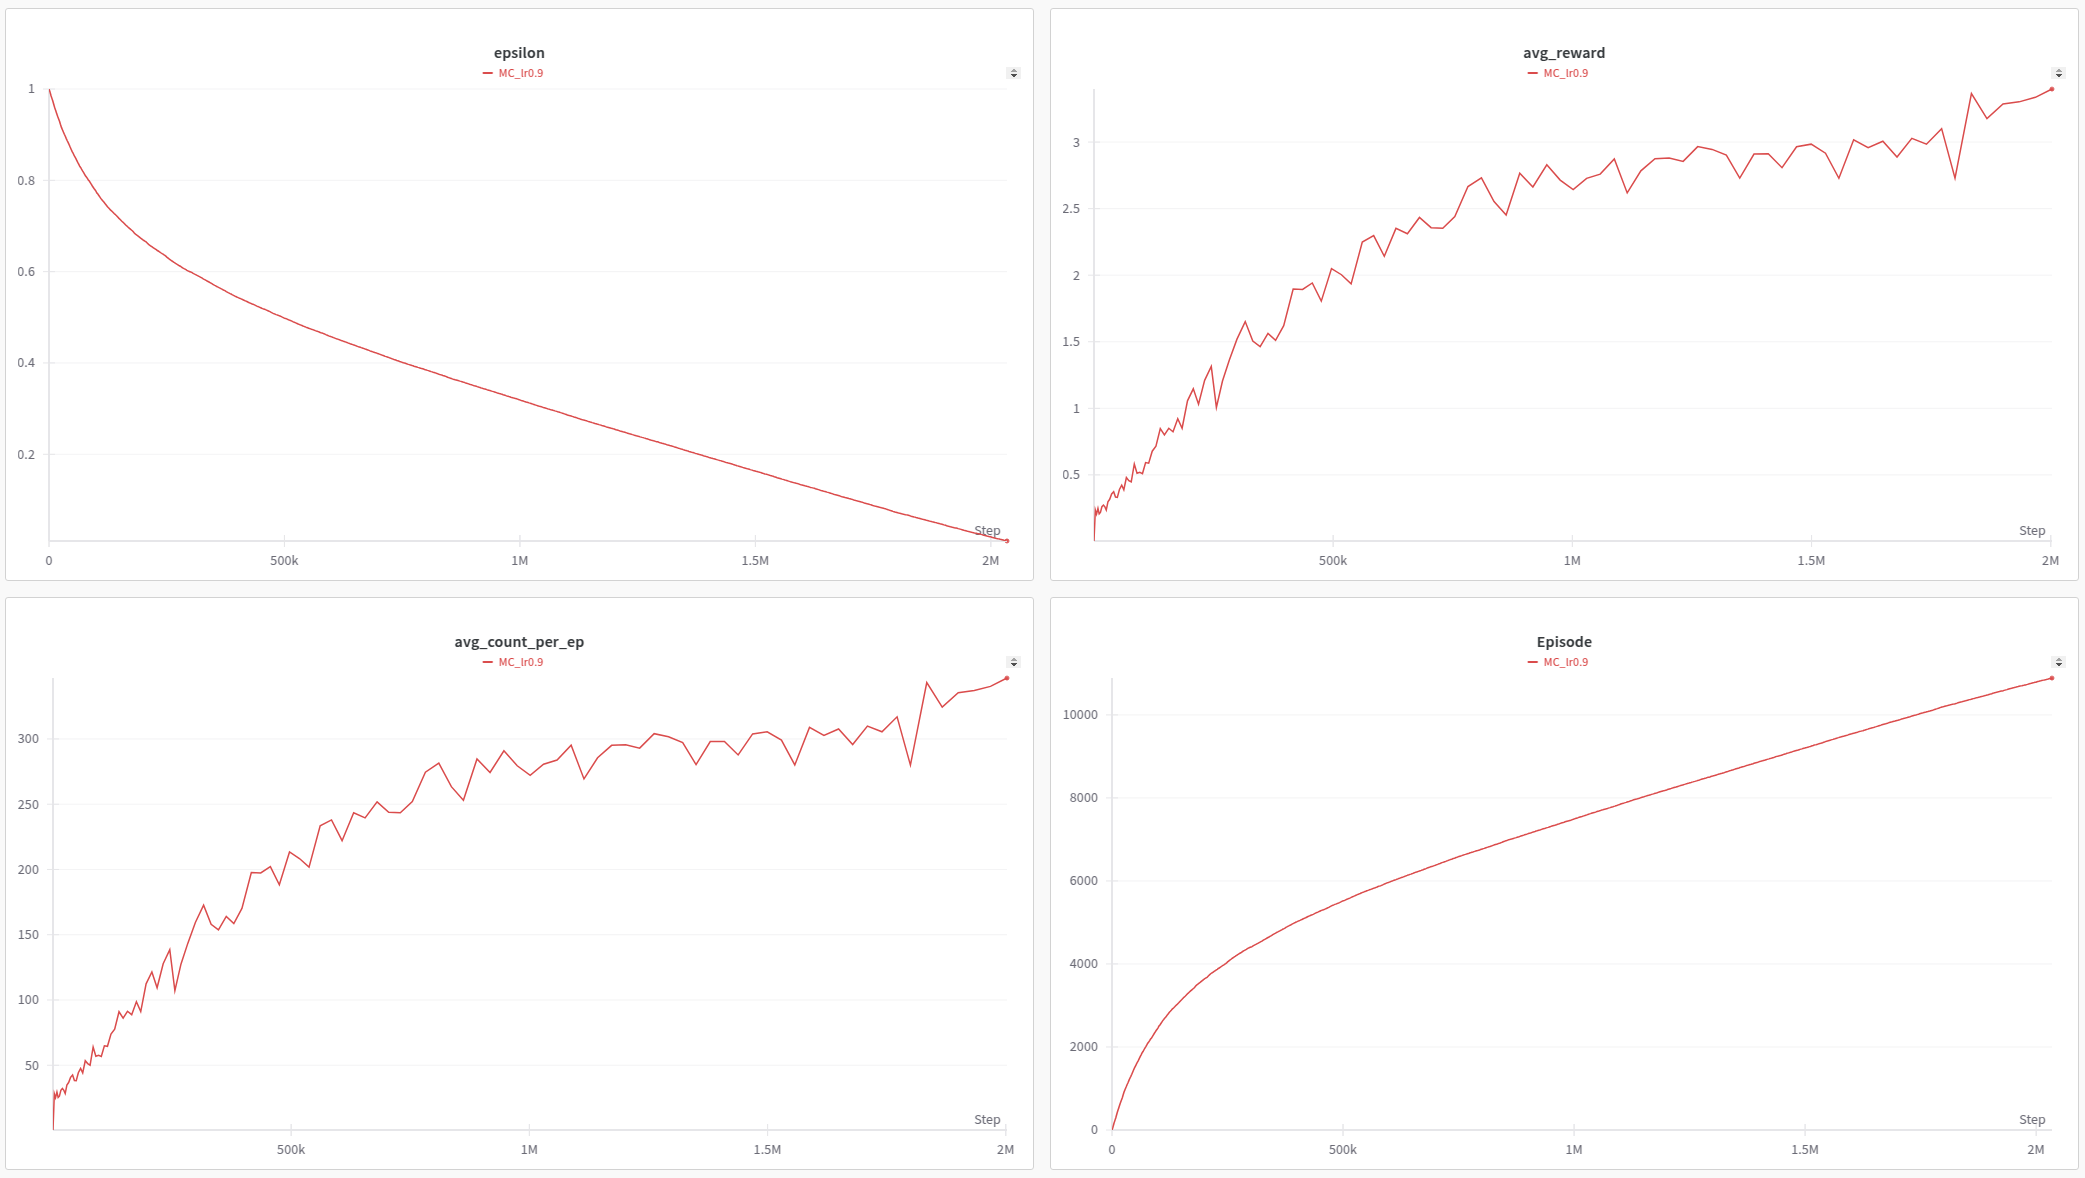

- เทียบกราฟ



**SARSA**
- Learning rate 0.1 (Discount 0.5)

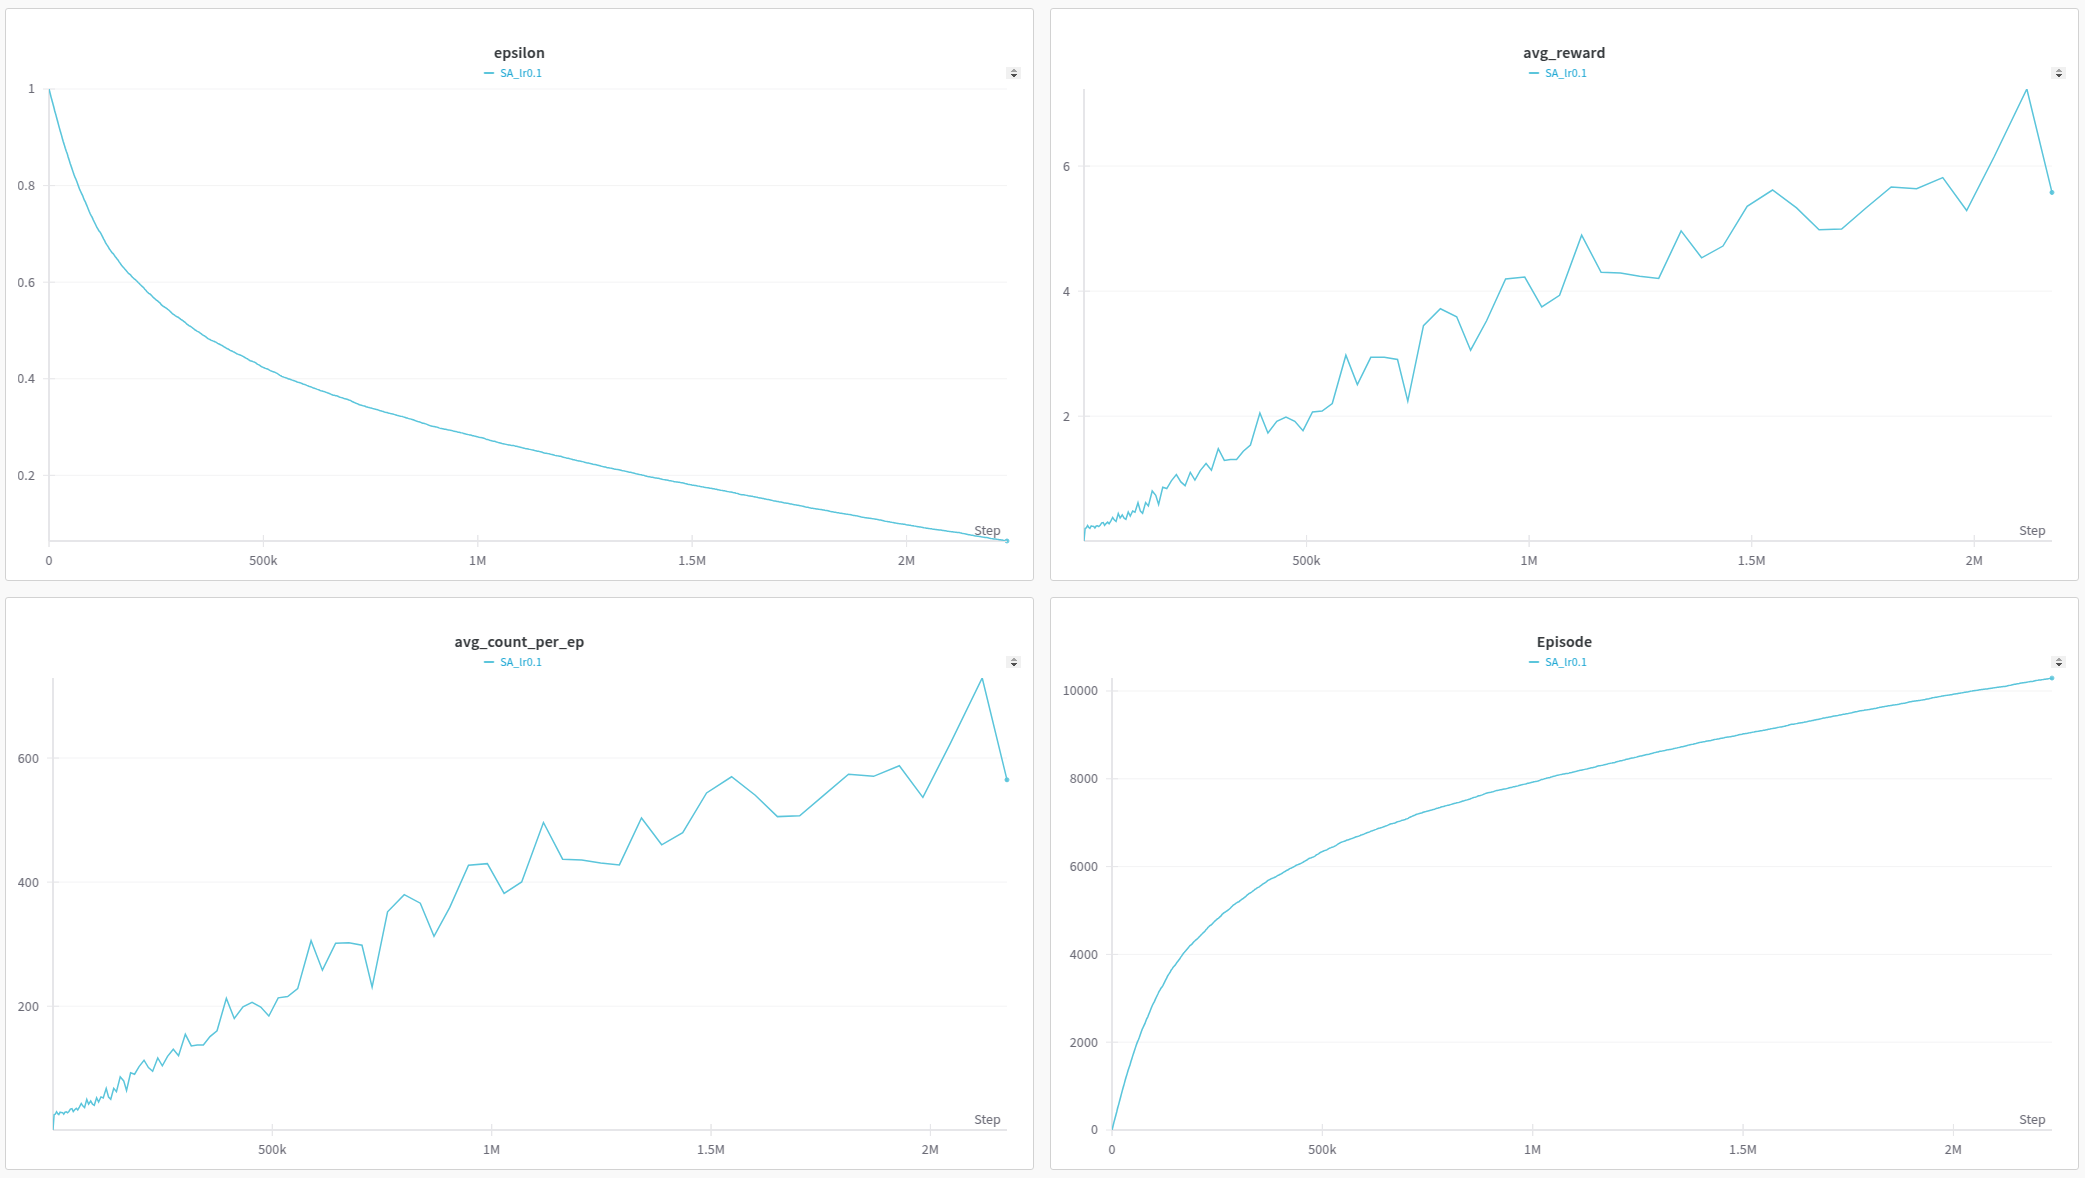

- Learning rate 0.3 (Discount 0.5)

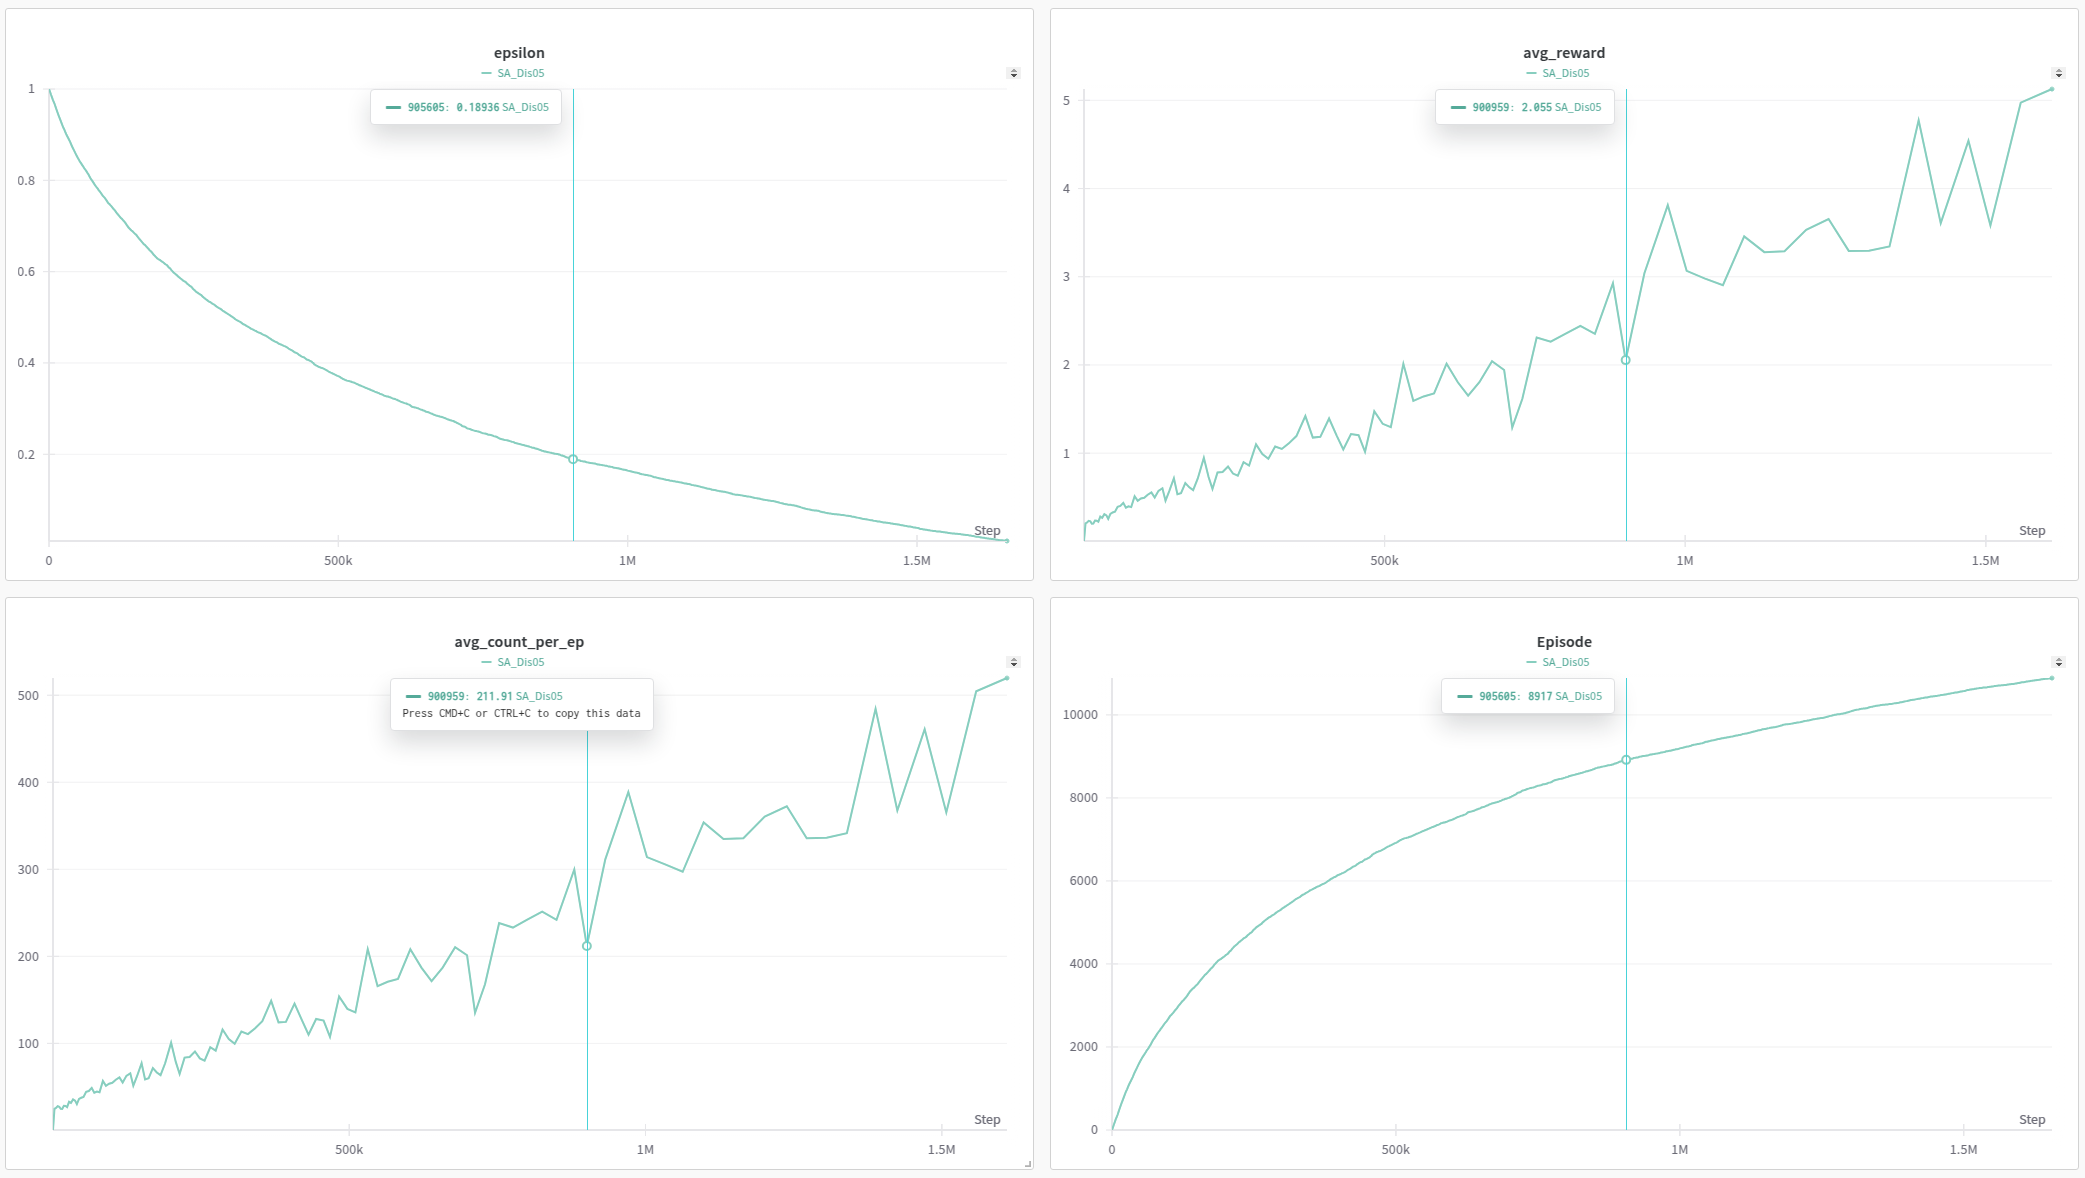

- Learning rate 0.9 (Discount 0.5)

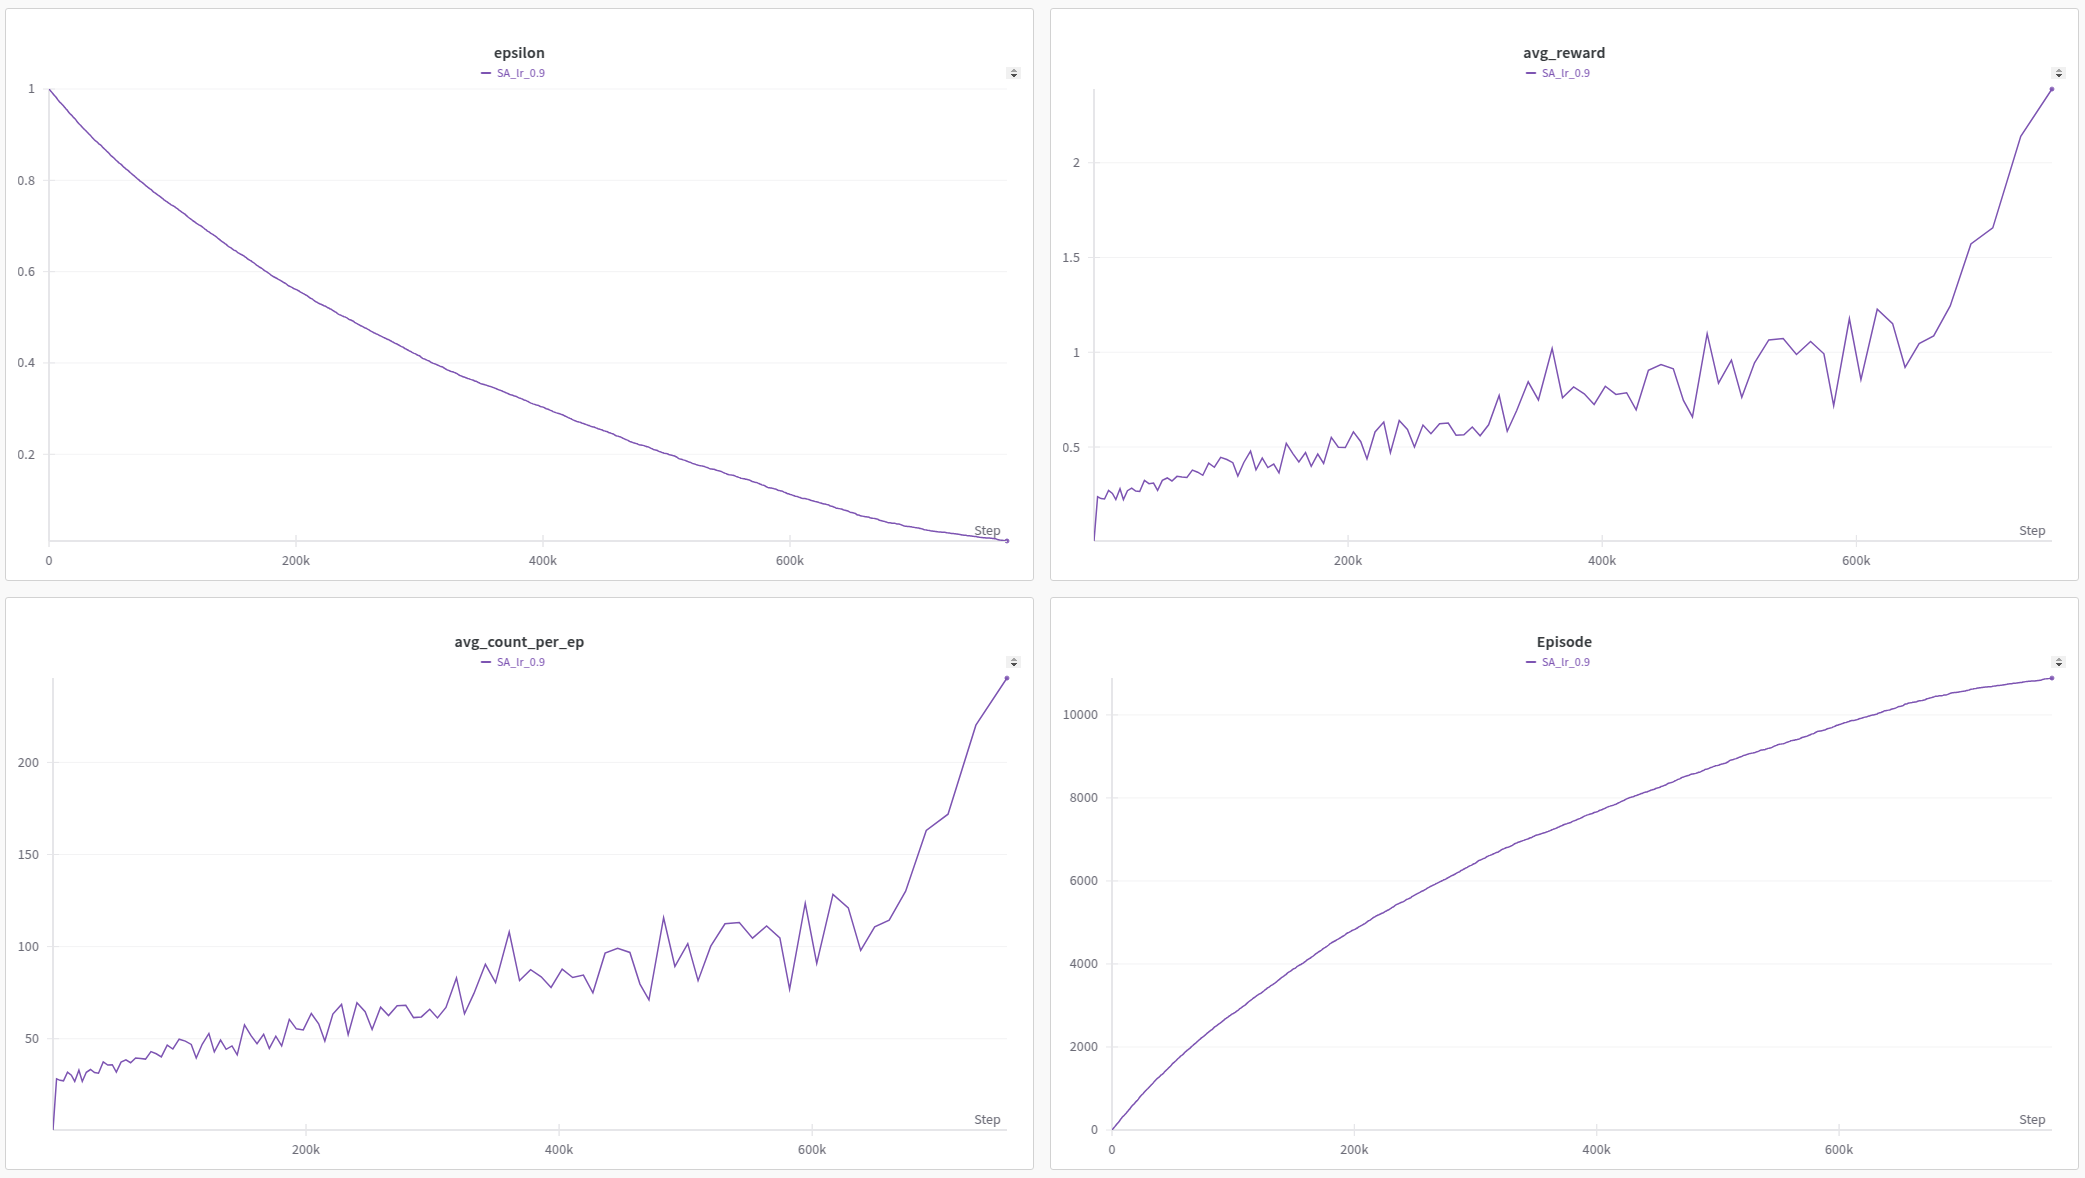


- เทียบกราฟ
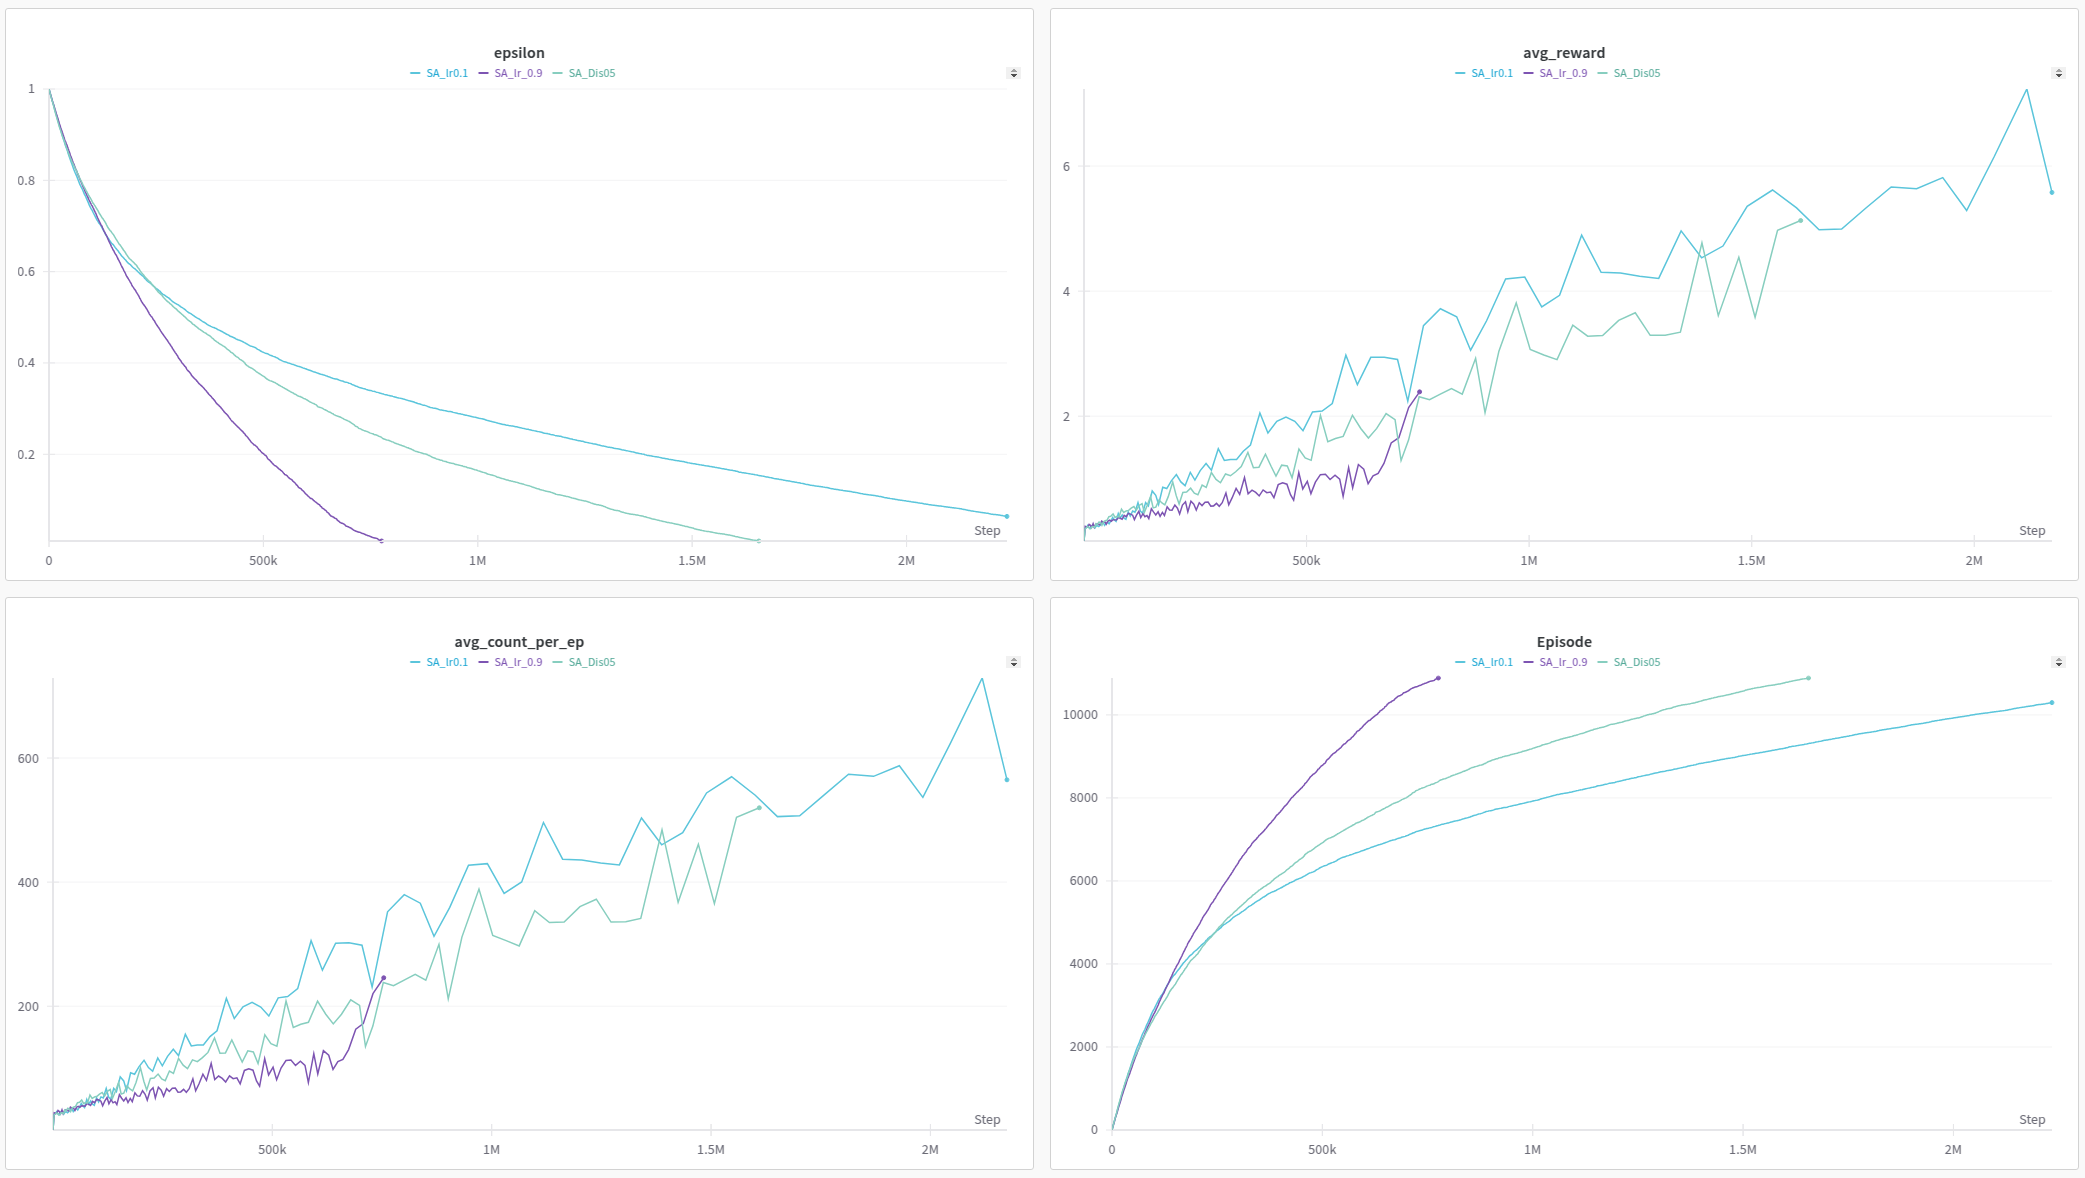

**Q-learning**

- Learning rate 0.1 (Discount 0.5)

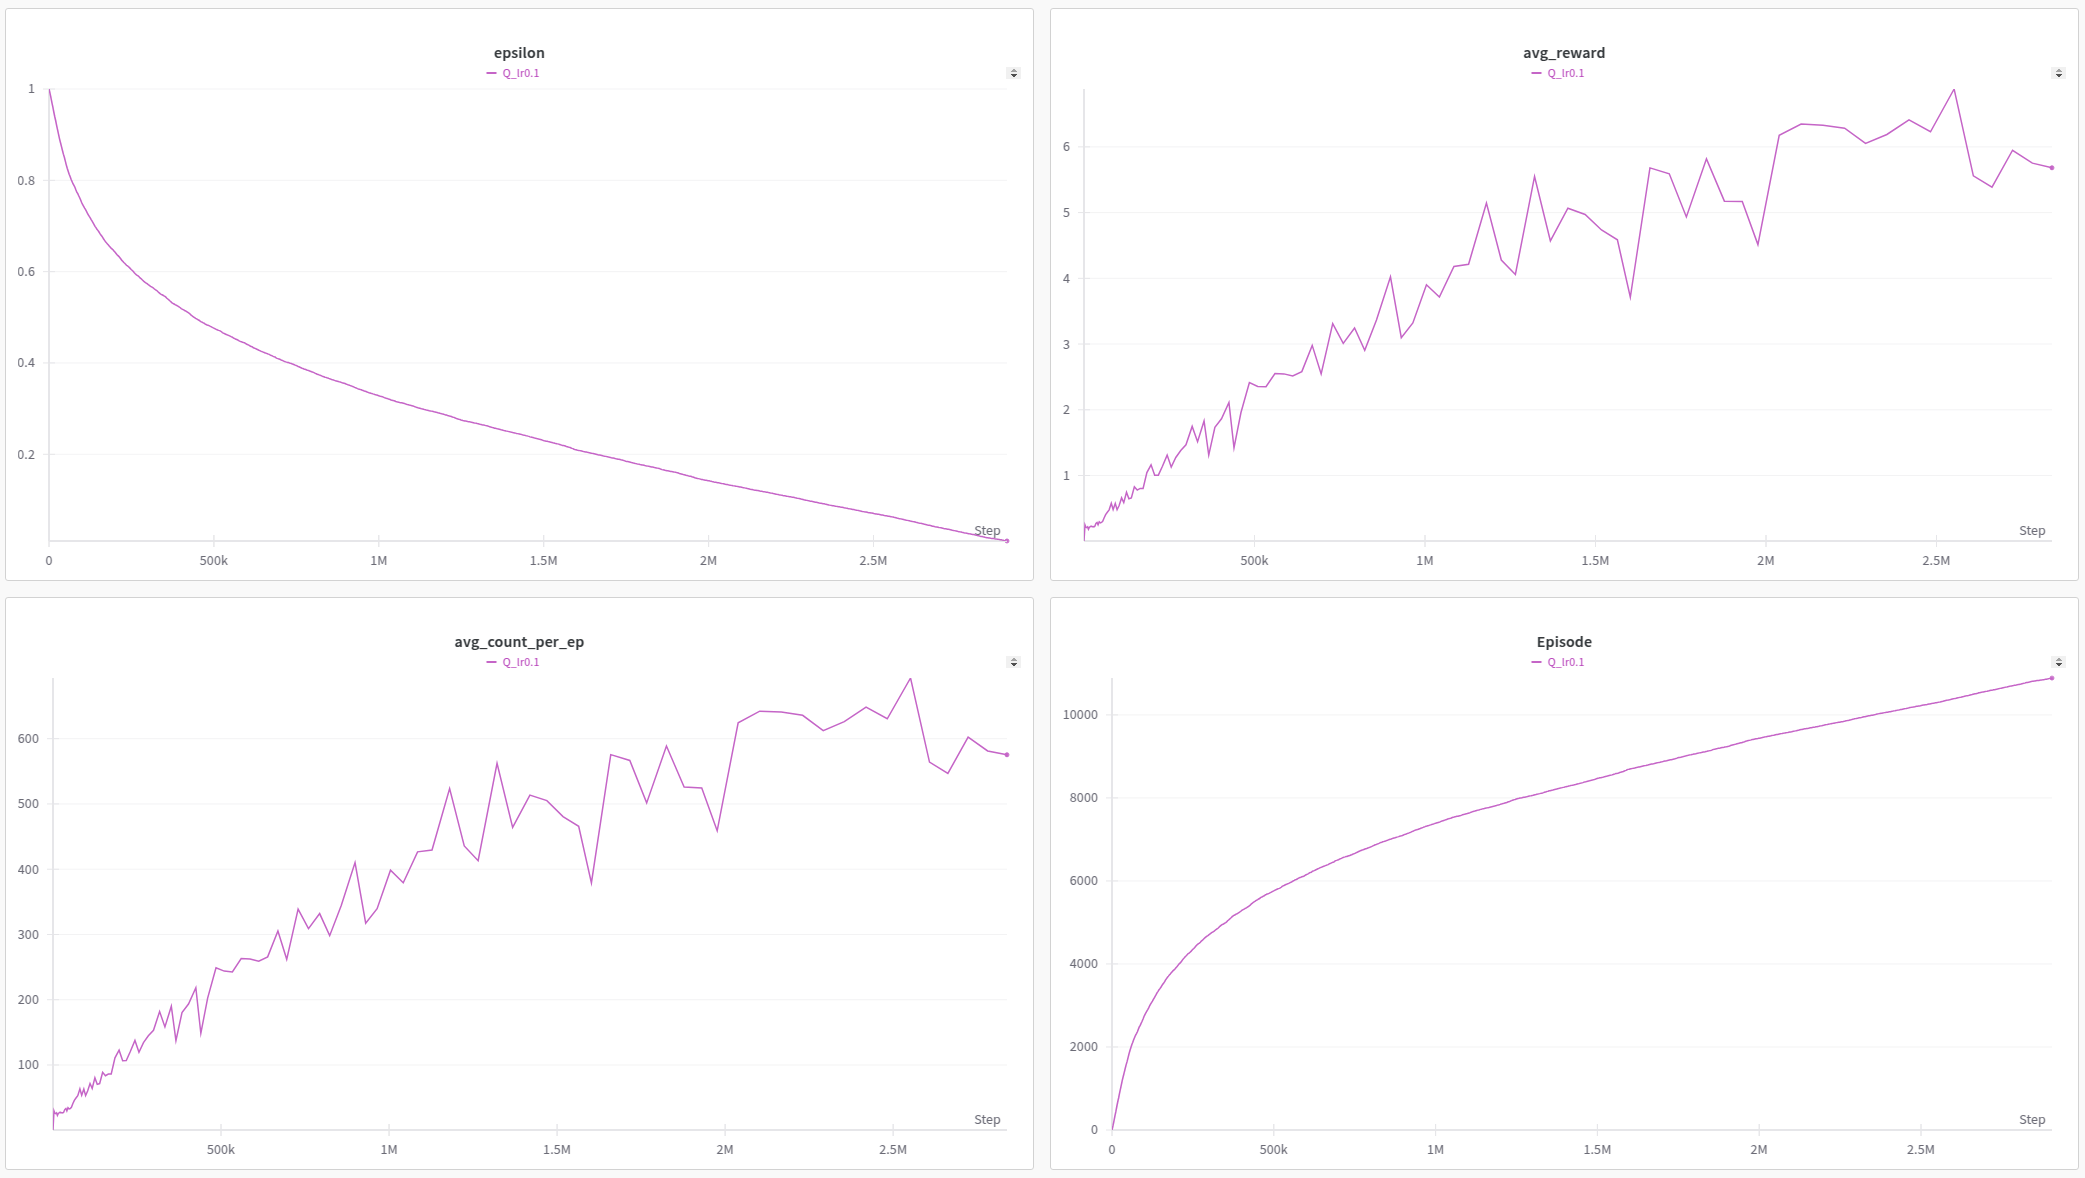

- Learning rate 0.3 (Discount 0.5)

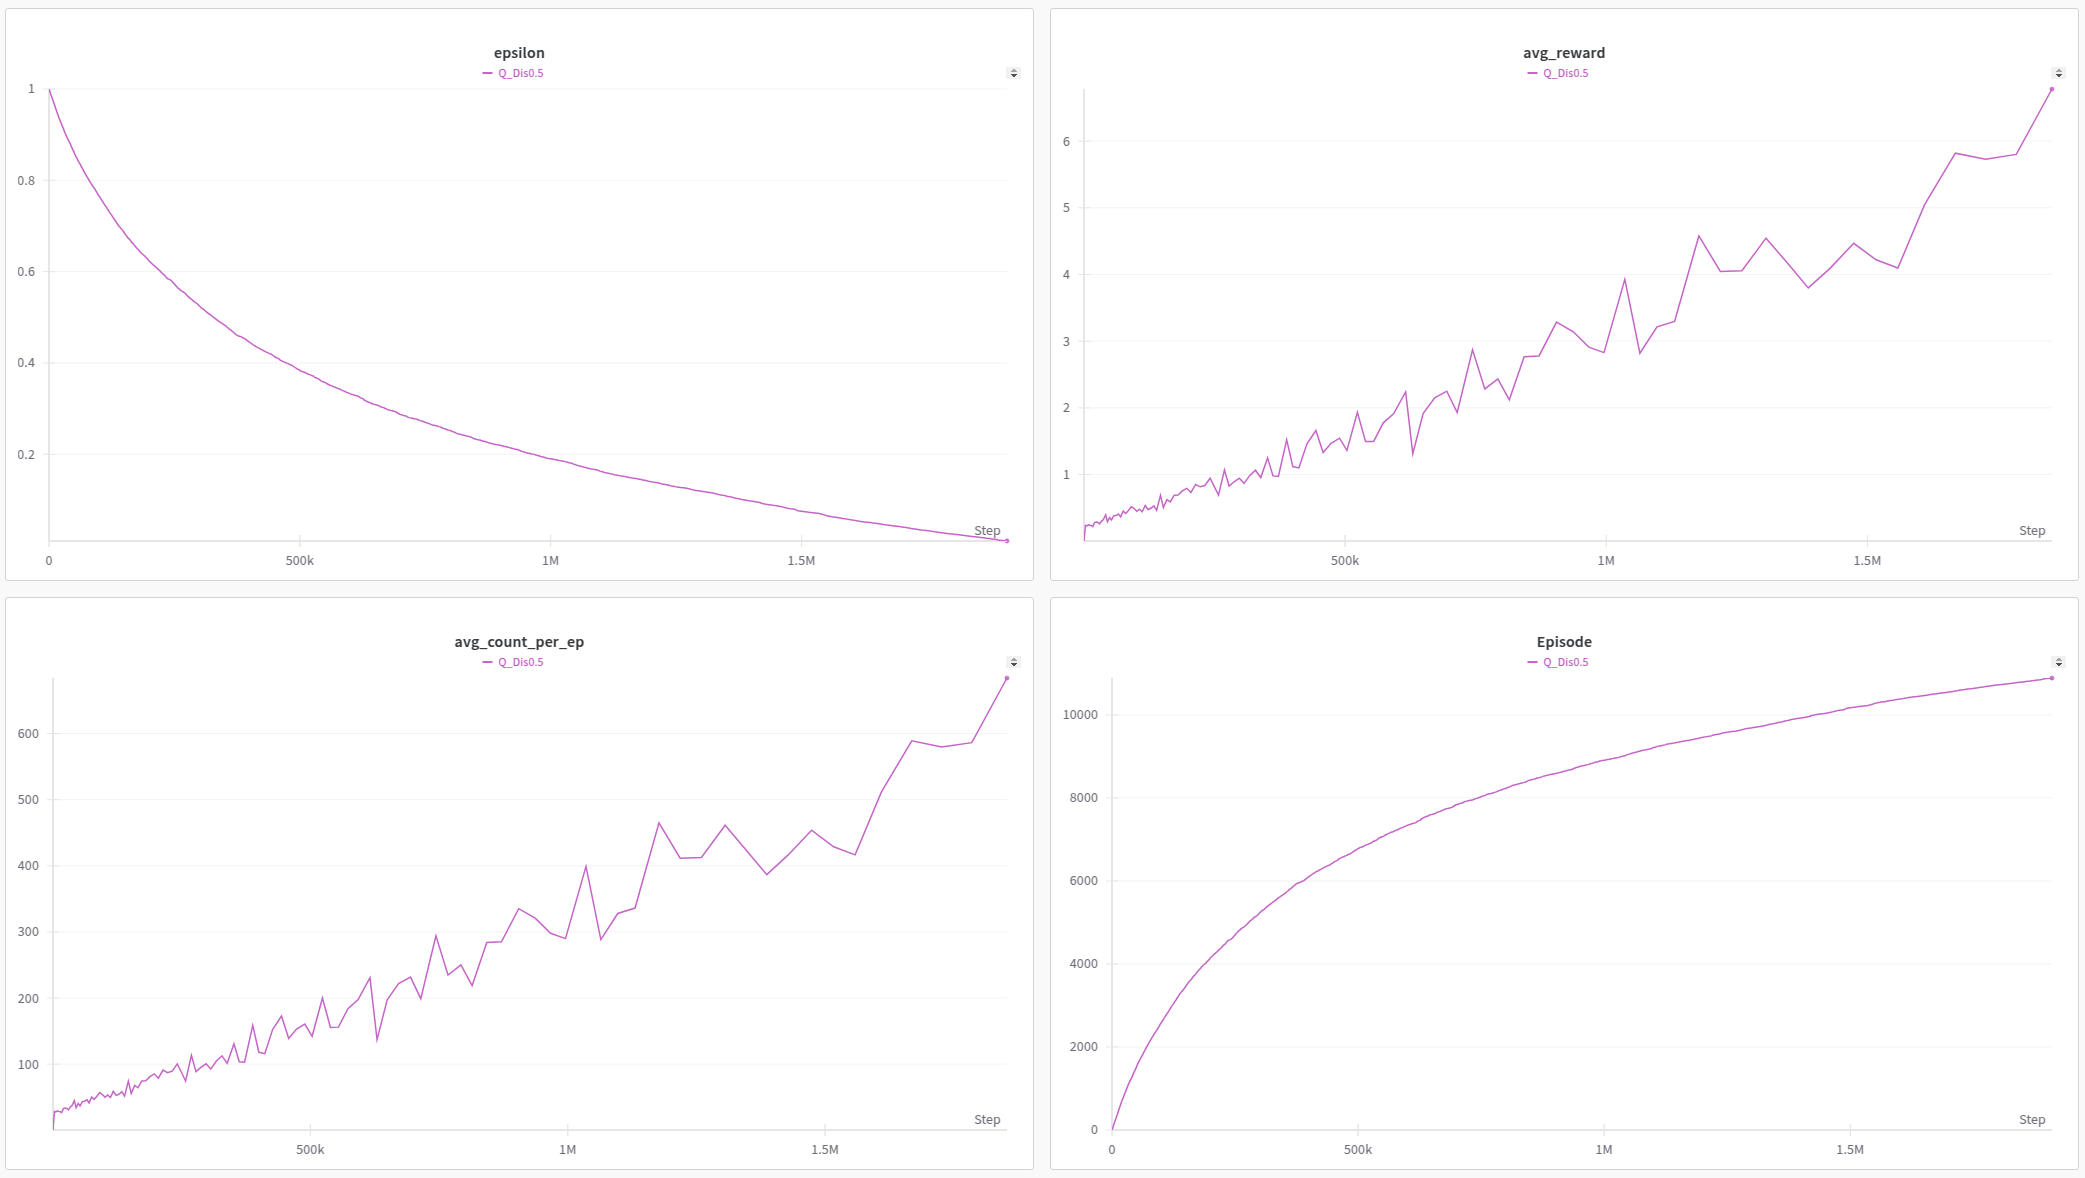

- Learning rate 0.9 (Discount 0.5)

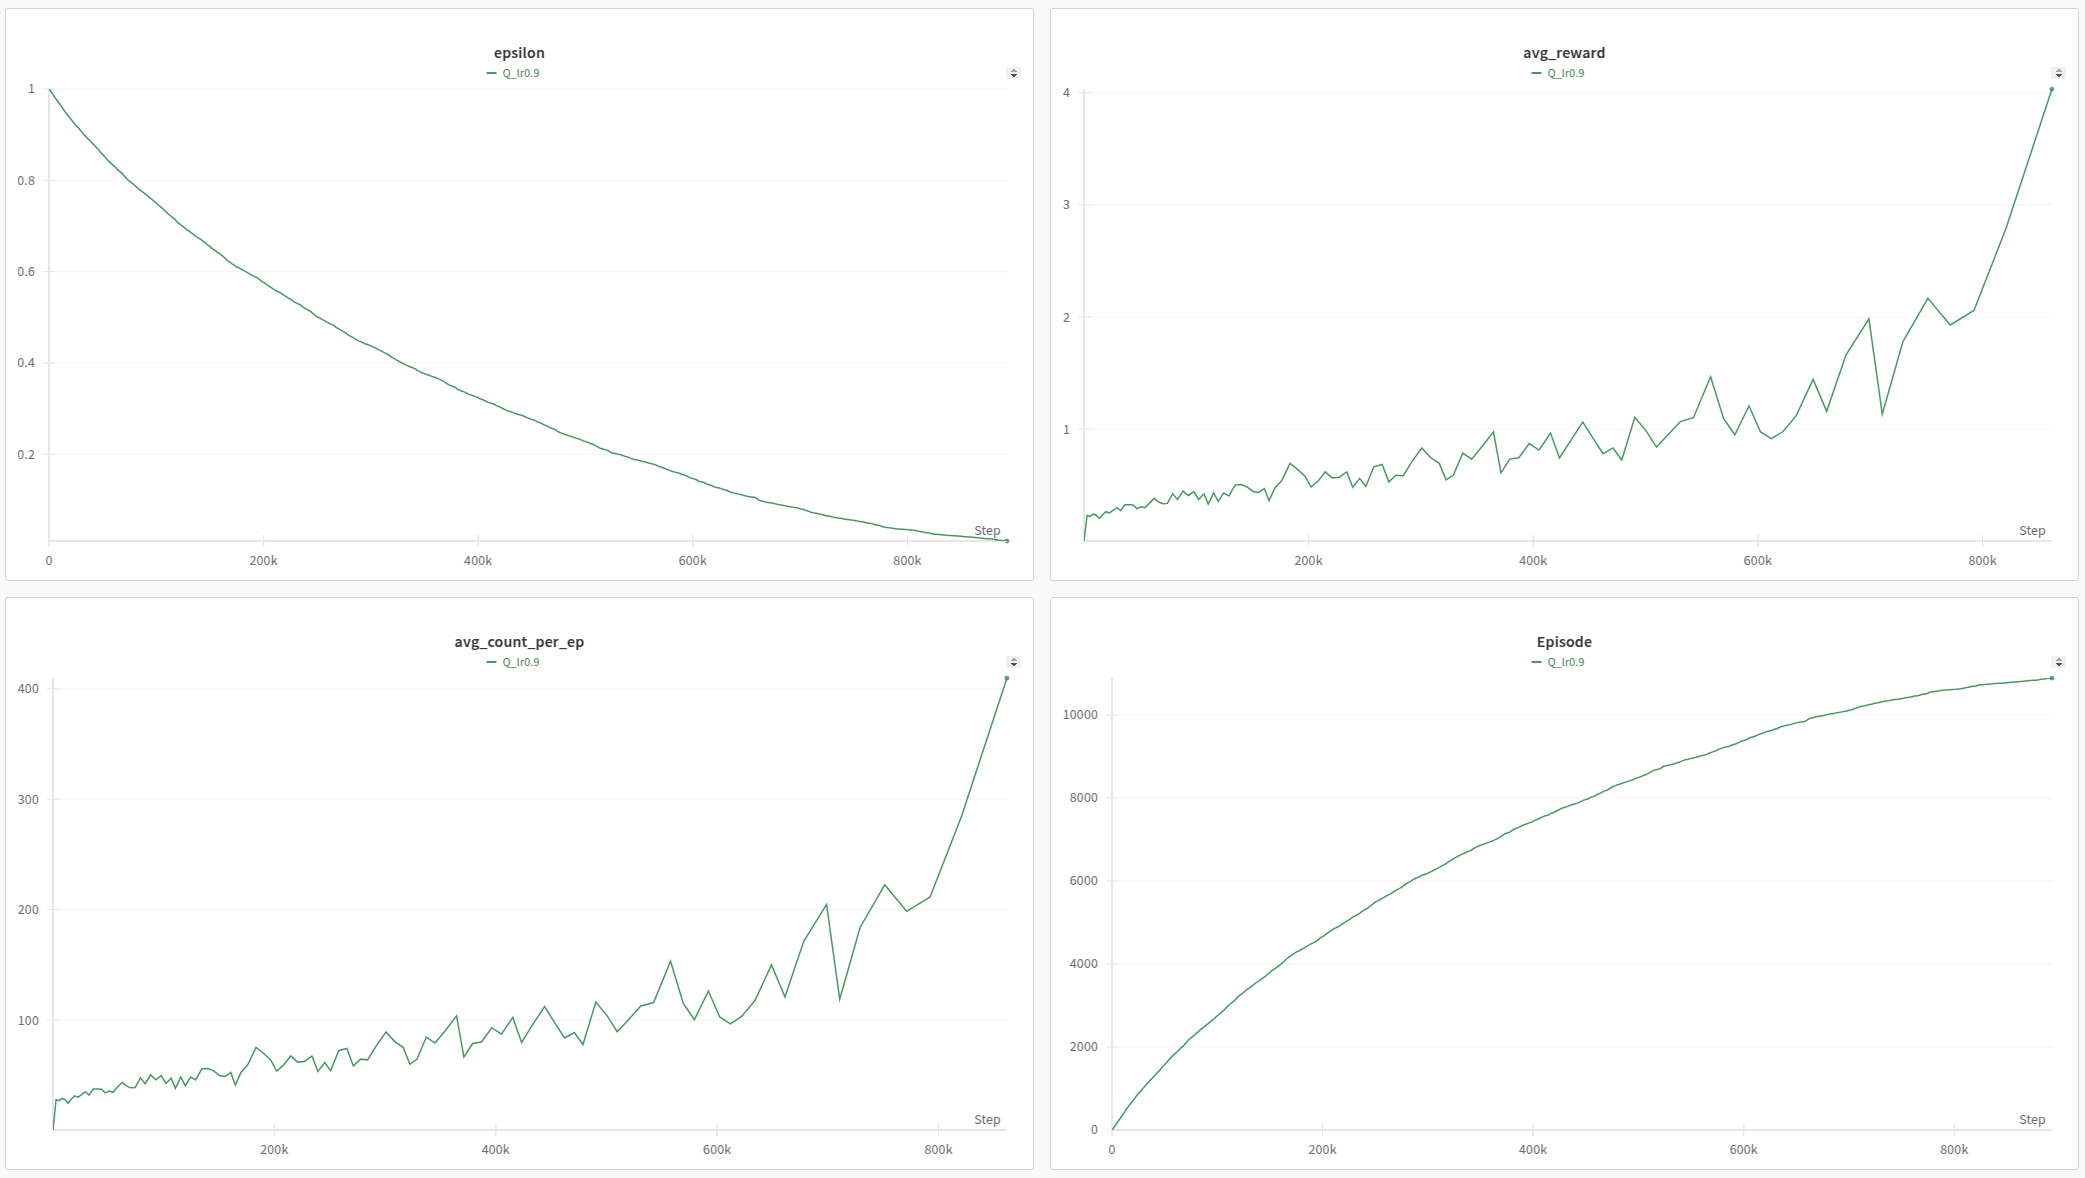

- เทียบกราฟ

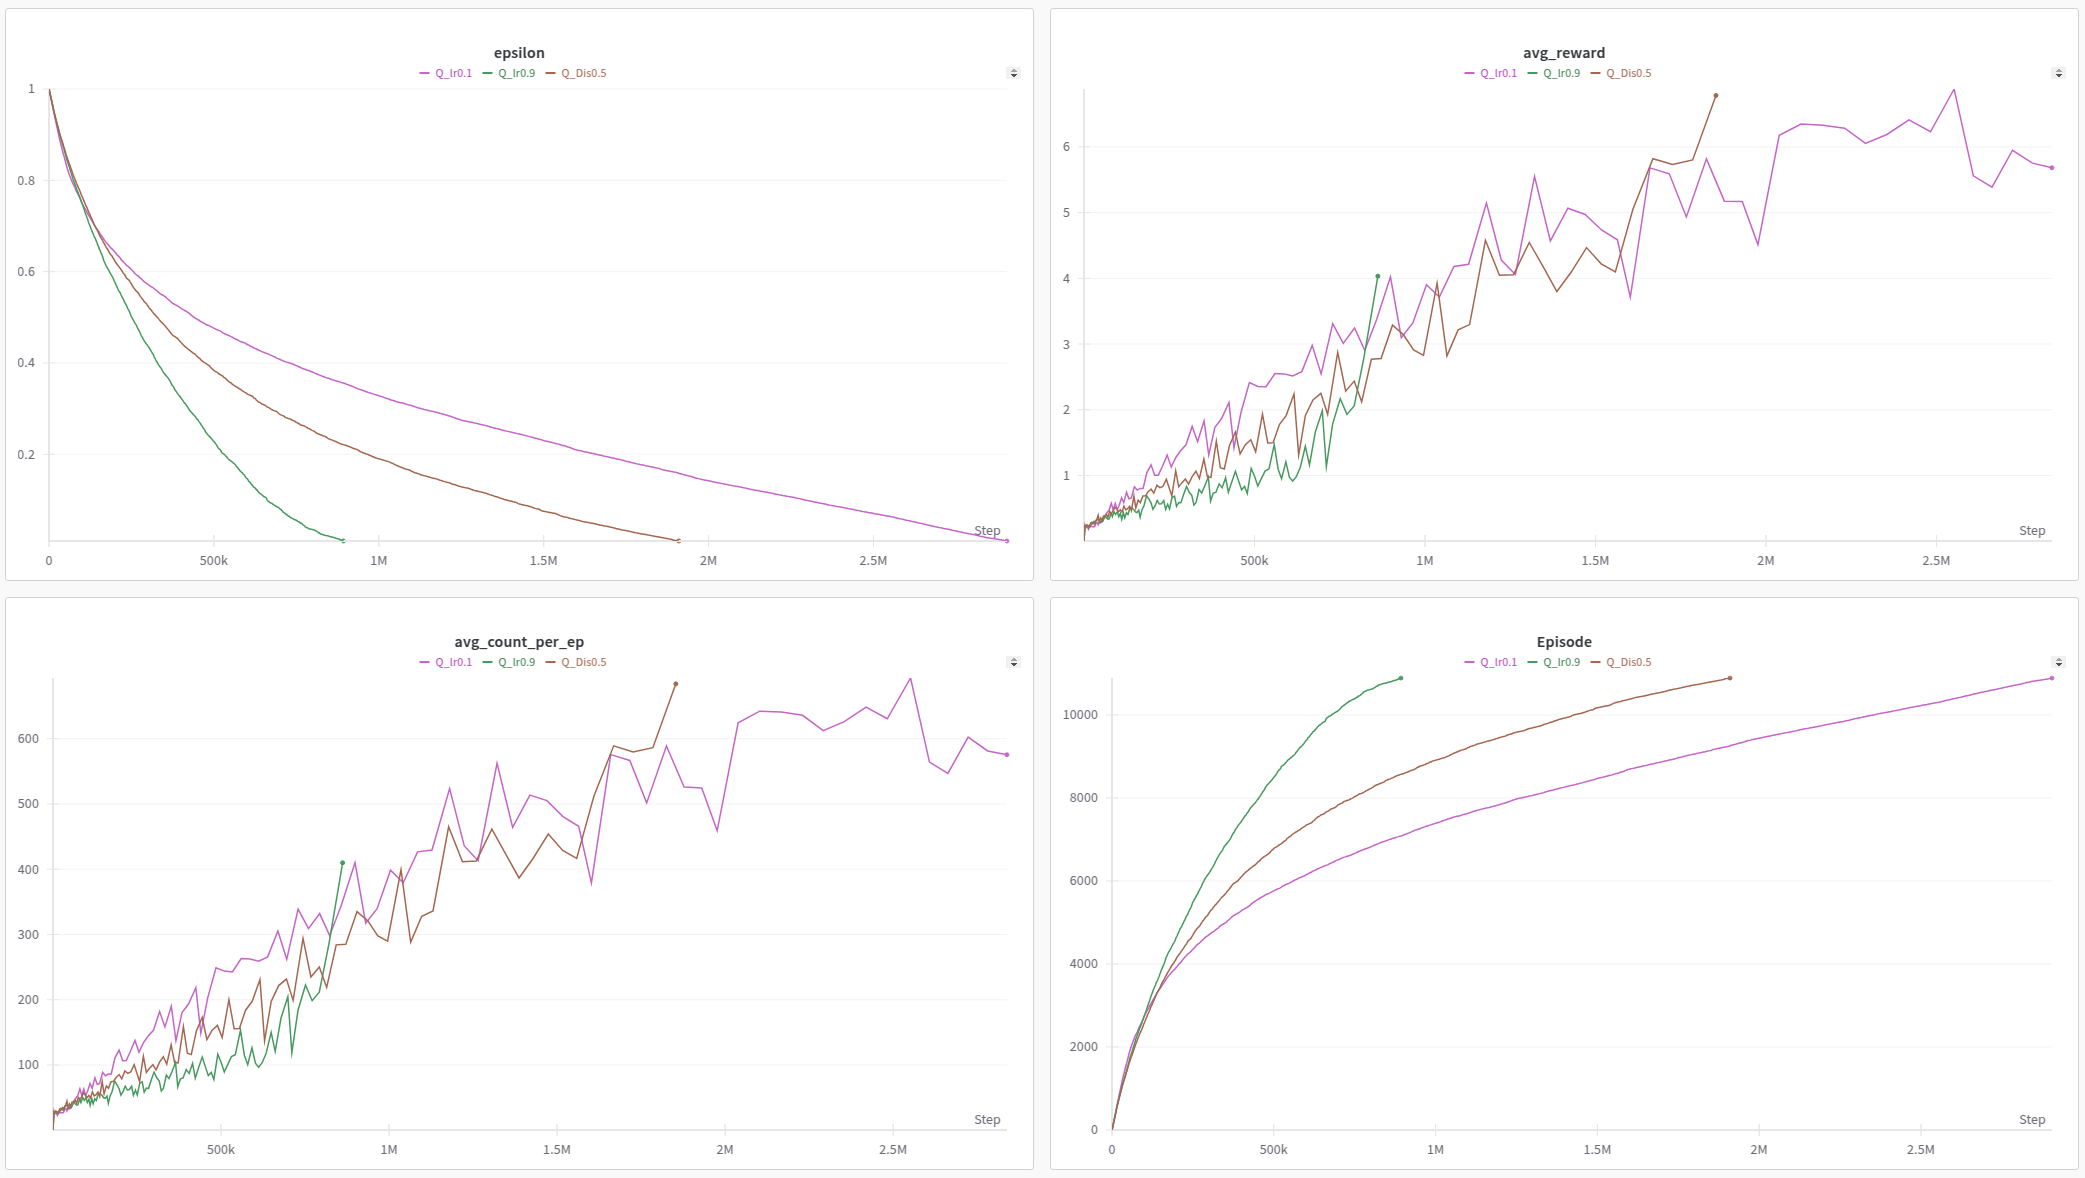

**Double-Q-learning**

- Learning rate 0.1 (Discount 0.5)

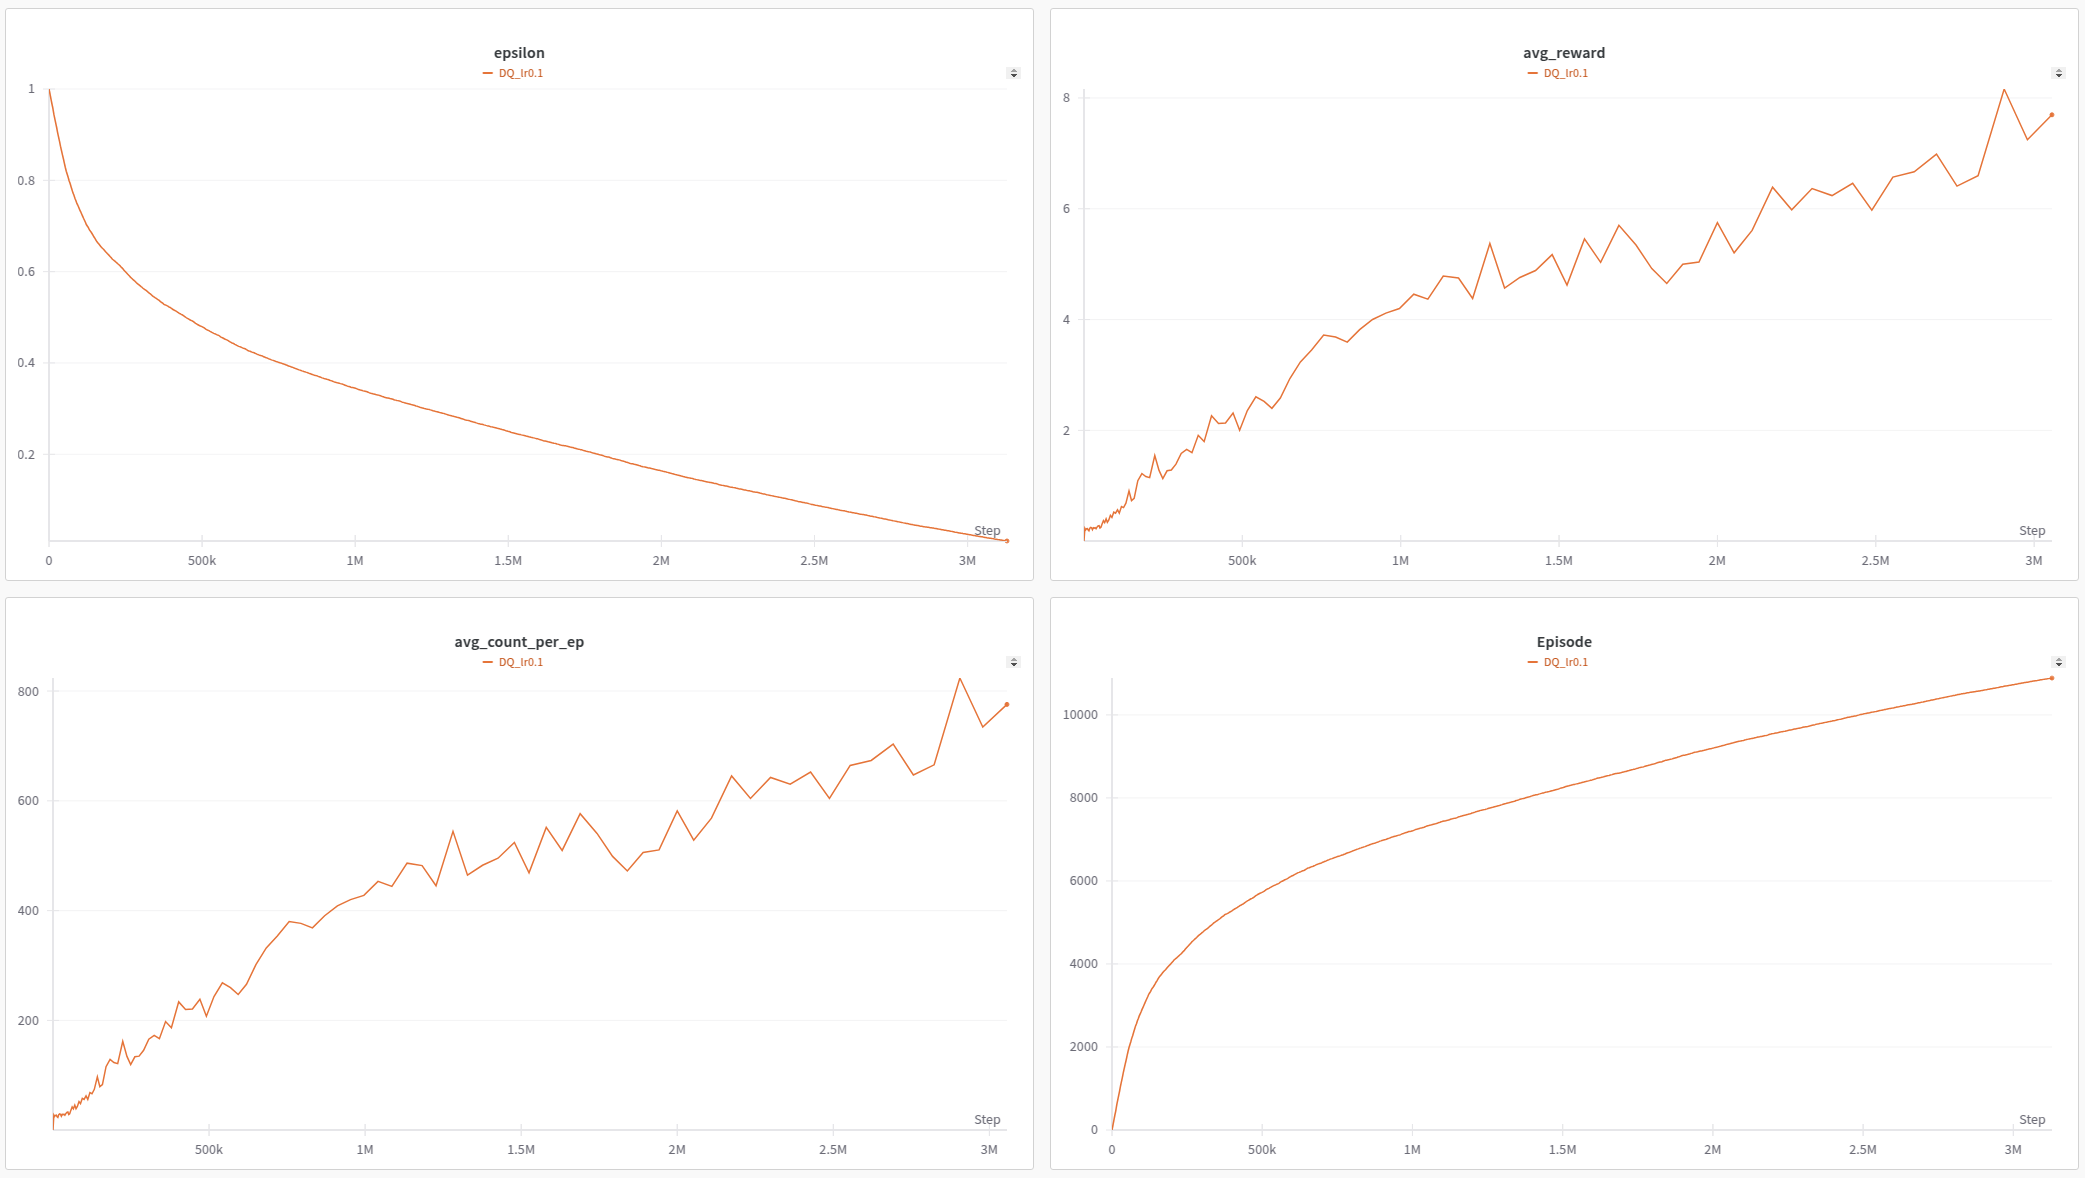

- Learning rate 0.3 (Discount 0.5)

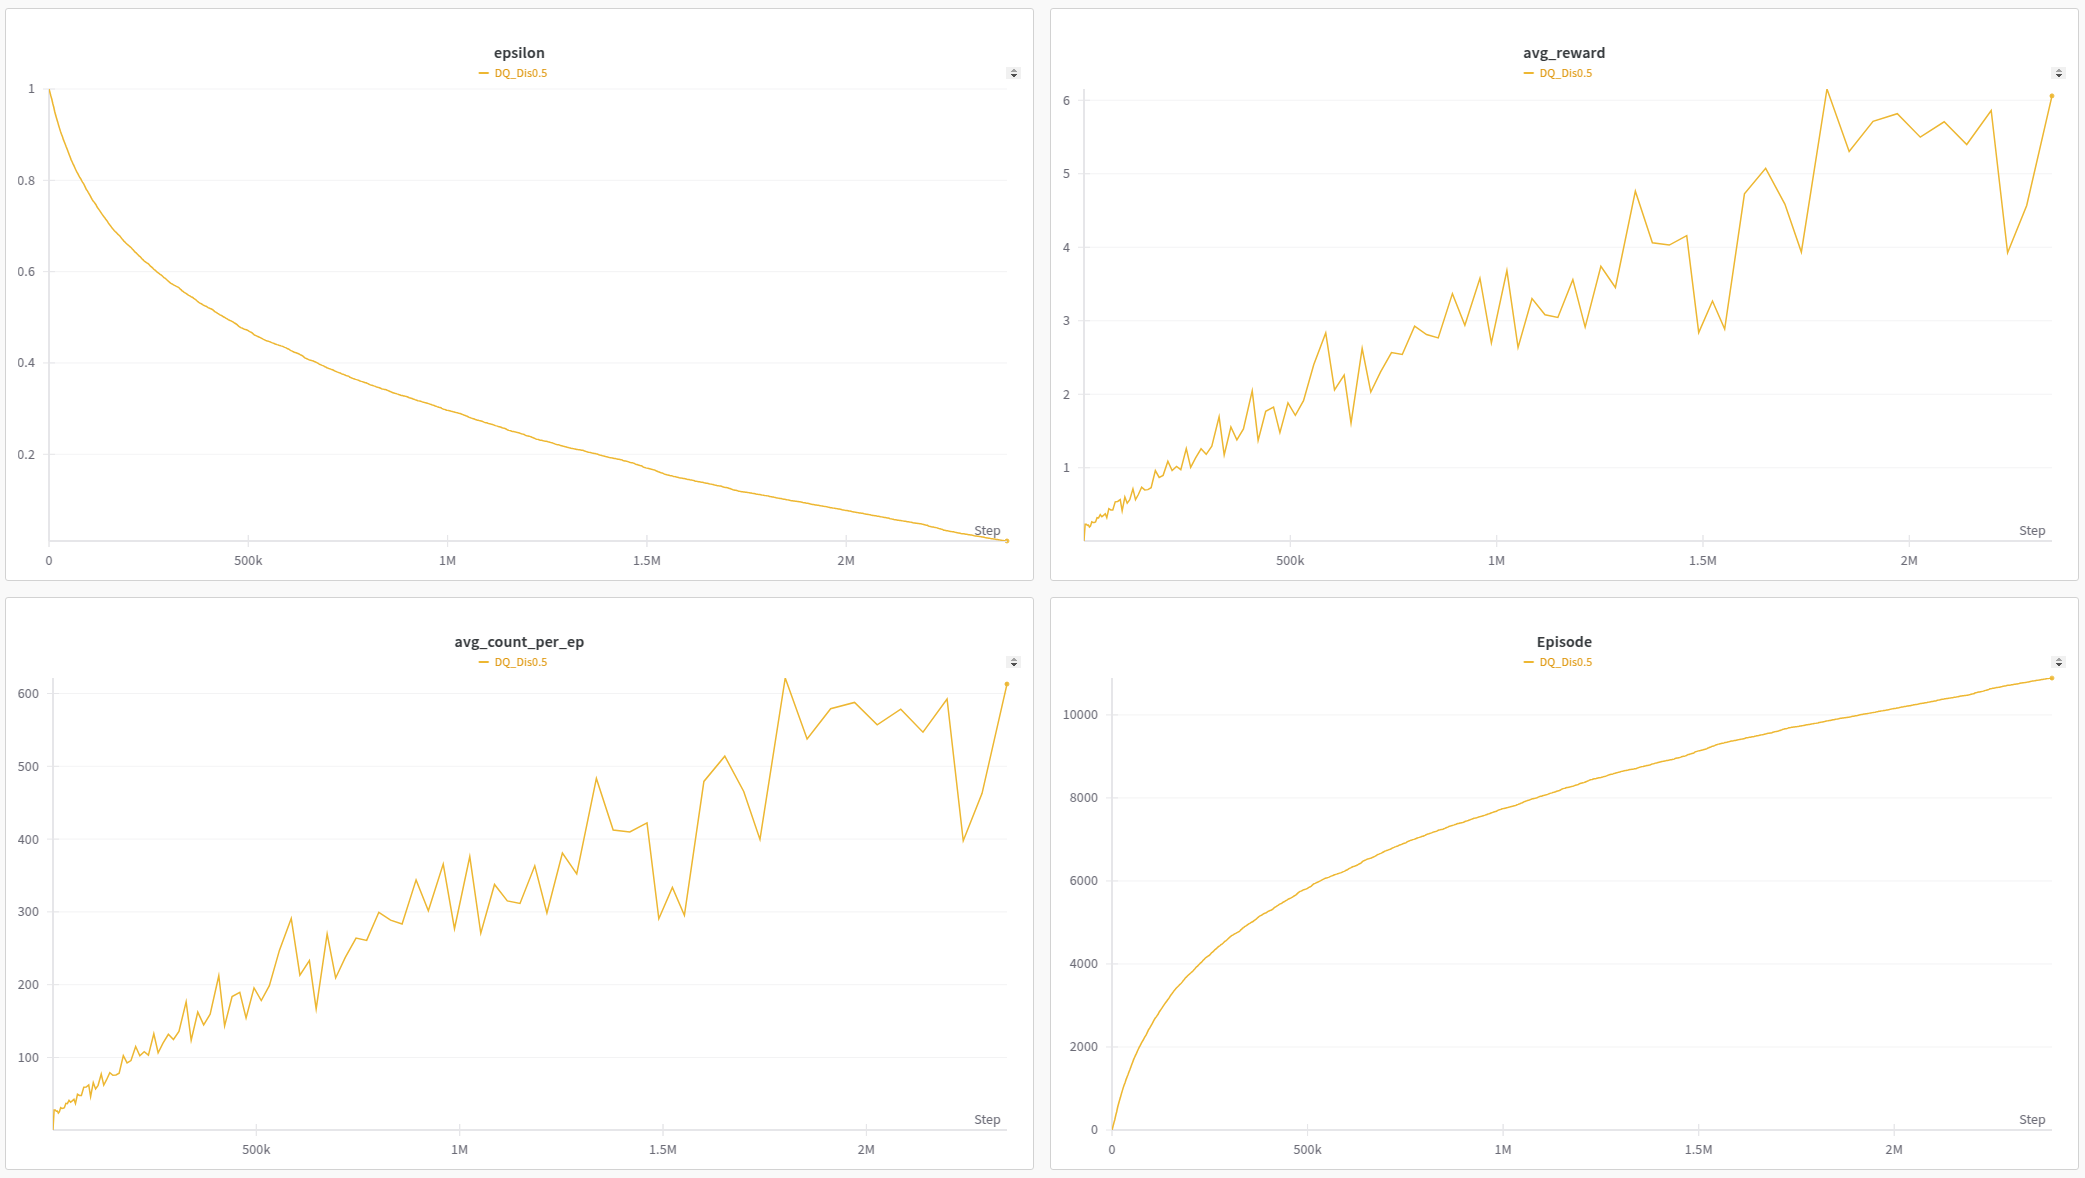

- Learning rate 0.9 (Discount 0.5)

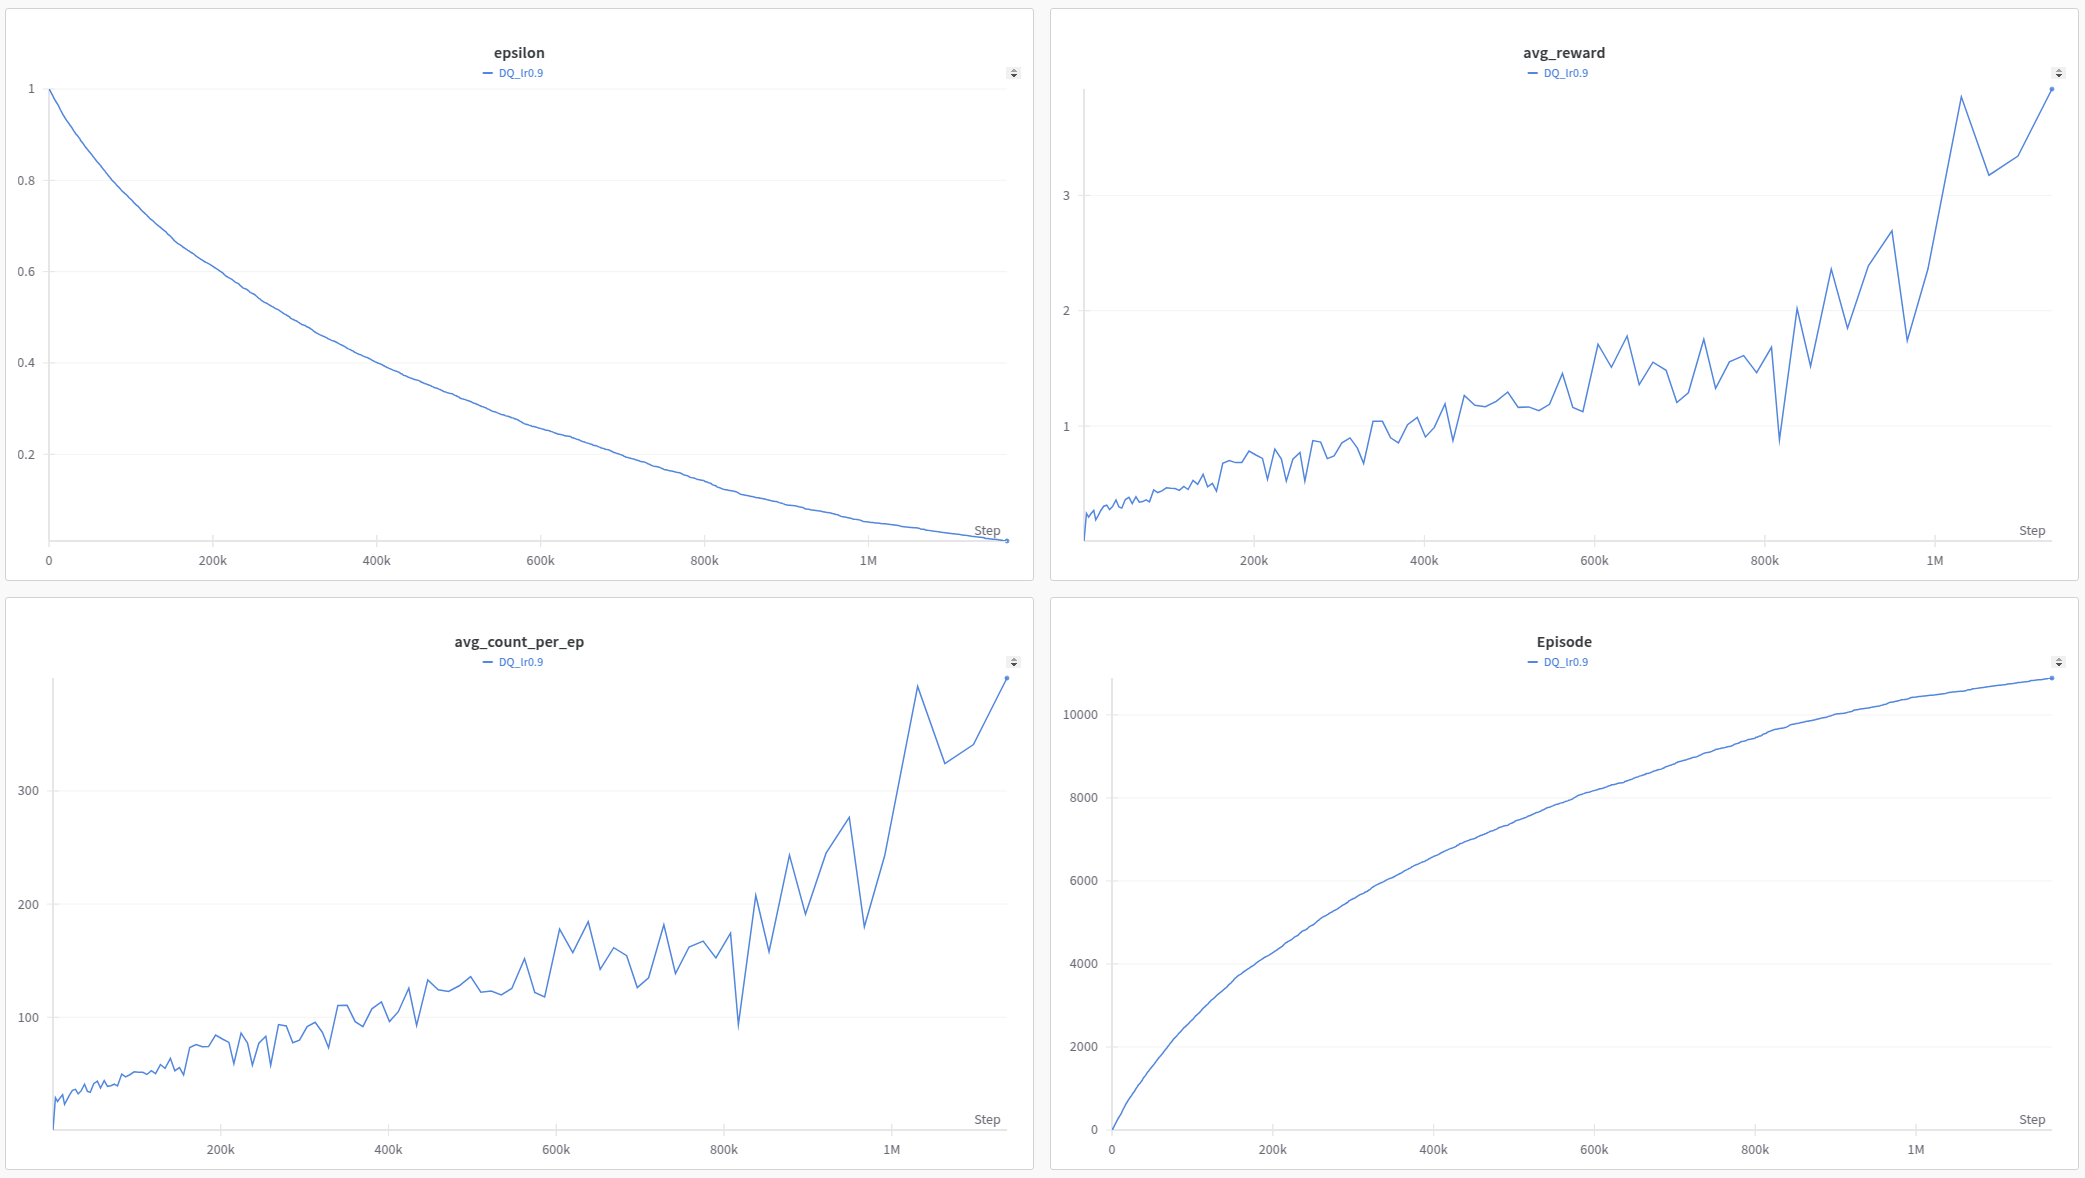

- เทียบกราฟ

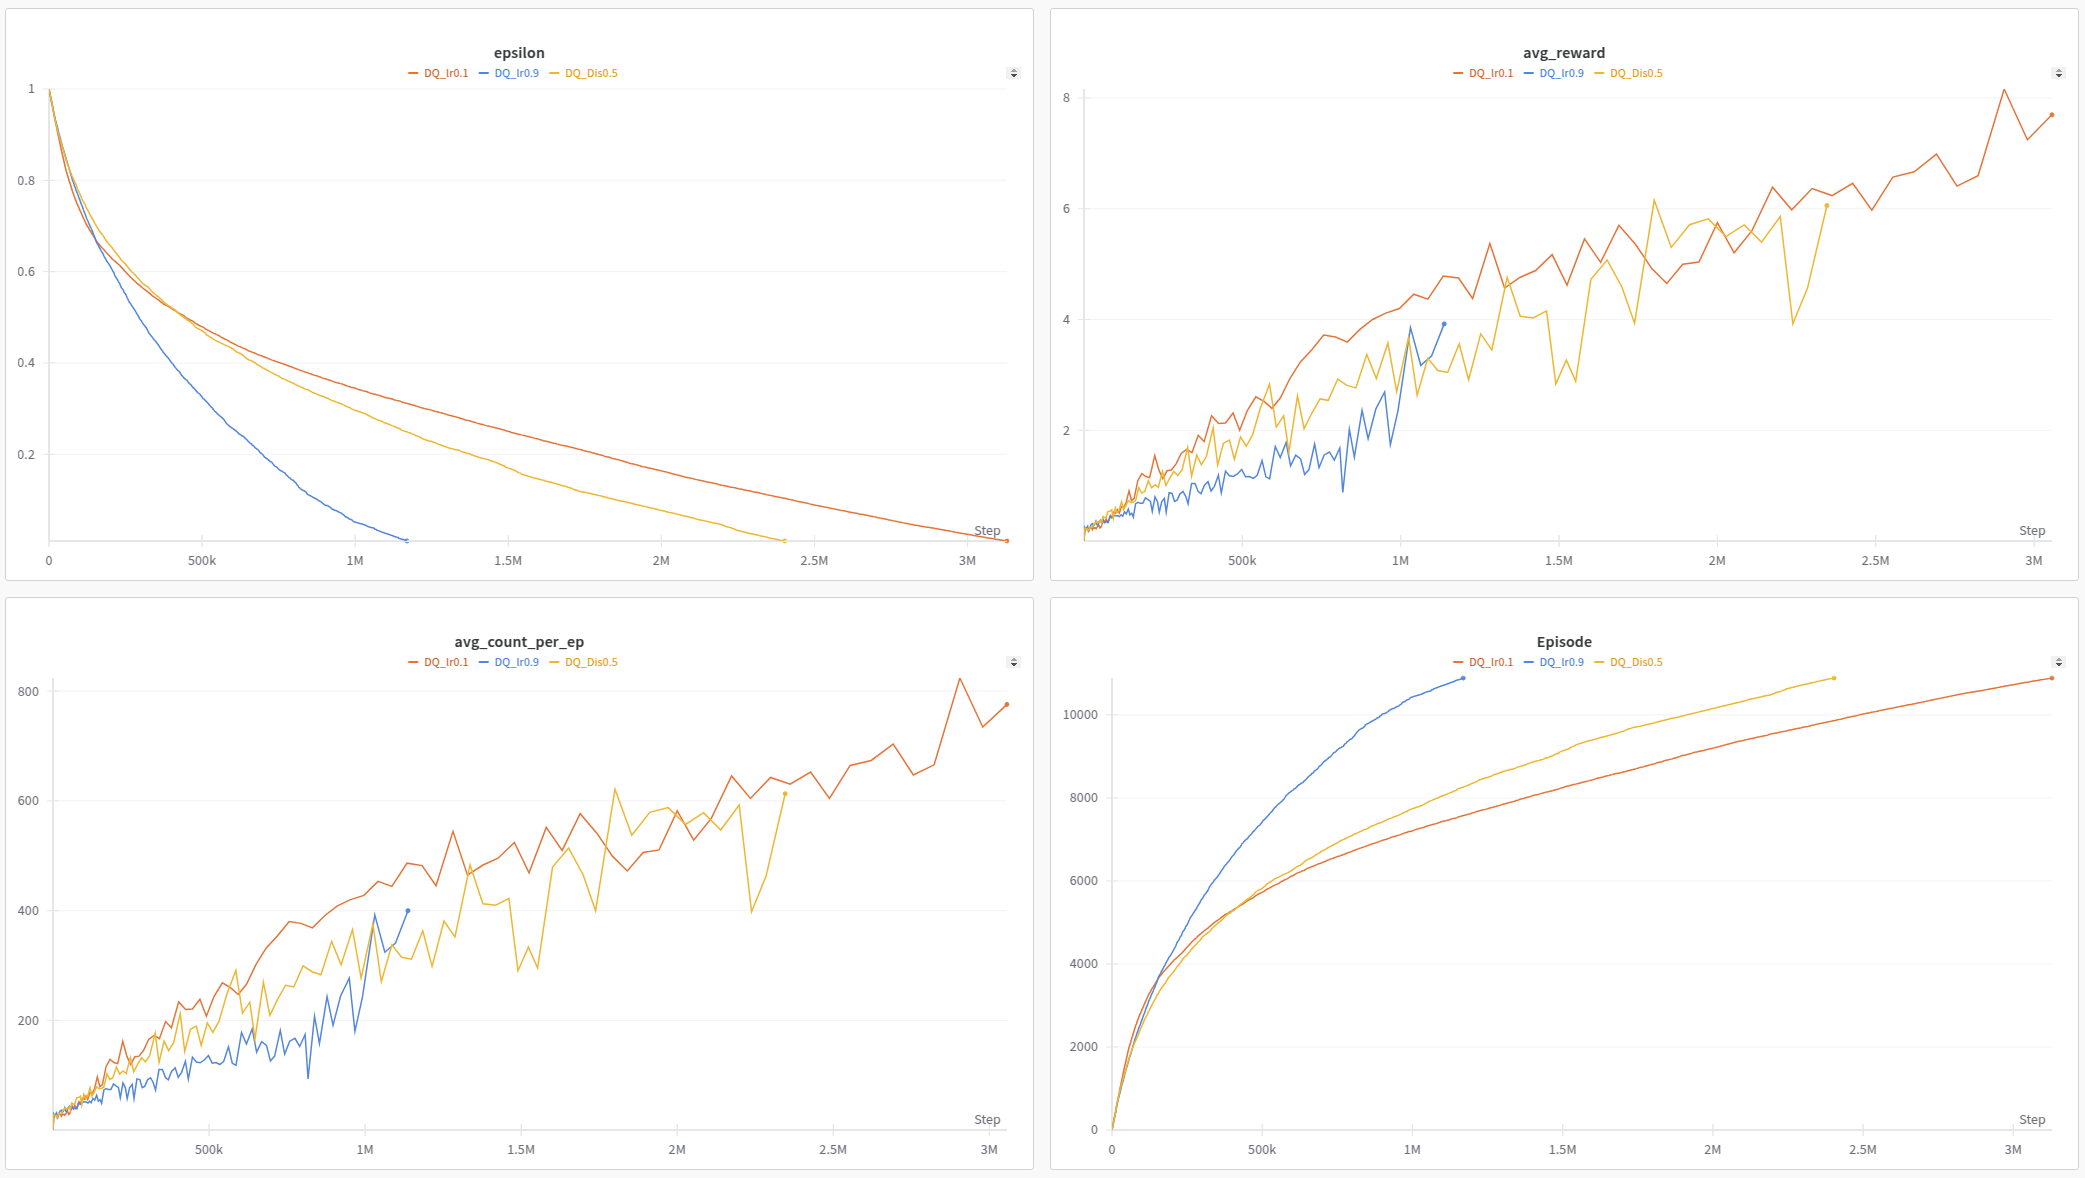

#### 2.2.ทำลองปรับ hyperparameters ในสภาพแวดล้อมที่มี state และ action space แบบ continuous 

**Learning Objective**

Explore approaches to implementing reinforcement learning in real-world scenarios where the state and action spaces are continuous.

**hyperparameters ที่จะปรับ**
1. num_of_action : 5 11 15 
2. discretize_state_weight 
    - เช็ค pose_cart : [11,1,1,1]
    - เช็ค pose_pole : [1,11,1,1]
    - เช็ค vel_cart  : [1,1,11,1]
    - เช็ค vel_pole  : [1,1,1,11]
    - เอา 2 ค่าที่ดีที่สุดมารวมกัน 


**ตัวแปรควบคุม**

ใช้ **Q-learning** (เลือกค่าตัวแปรควบคุมจาก best value ของการทดลองที่ 1)

- learning_rate = 0.1

- action_range = [-16.0, 16.0]

- discount = 0.9

- n_episodes = num_of_action * discretize_state_weight[0] * discretize_state_weight[1] * discretize_state_weight[2] * discretize_state_weight[3]*2 

**episodes เปลี่ยนไปตาม discretize_state กับ num_of_action

##### 1. Num of action

##### 2. discretize_state_weight

### 3. Implement main() in play script (in the "Can be modified")

#### 3.1. hyperparameters tuning

In [ ]:
# hyperparameters
num_of_action = 11
action_range = [-16.0 , 16.0]  # [min, max]
discretize_state_weight = [5, 11, 3, 3]  # [pose_cart:int, pose_pole:int, vel_cart:int, vel_pole:int]
learning_rate = 0.3
# n_episodes = num_of_action * discretize_state_weight[0] * discretize_state_weight[1] * discretize_state_weight[2] * discretize_state_weight[3]*2
n_episodes = 10000
start_epsilon = 0
epsilon_decay = 0 # reduce the exploration over time
final_epsilon = 0
discount = 0.50

#### 3.2. Select Json file

In [ ]:
task_name = str(args_cli.task).split('-')[0]  # Stabilize, SwingUp
Algorithm_name = "Q_Learning"  

episode = 26800 #Edit here to match a episode on json file
    
q_value_file = f"{Algorithm_name}_{episode}_{num_of_action}_{action_range[1]}_{discretize_state_weight[0]}_{discretize_state_weight[1]}_{discount}_{learning_rate}.json"
print(q_value_file) #Verify that correct json

full_path = os.path.join(f"q_value/{task_name}", Algorithm_name)
agent.load_model(full_path, q_value_file)

#### 3.3. Play Loop

In [ ]:
# reset environment
obs, _ = env.reset()
timestep = 0
# simulate environment
while simulation_app.is_running():
    # run everything in inference mode
    with torch.inference_mode():
        for episode in range(n_episodes):
            obs, _ = env.reset()
            done = False

            while not done:
                # agent stepping
                action, action_idx = agent.get_action(obs)
                # env stepping
                next_obs, reward, terminated, truncated, _ = env.step(action)

                done = terminated or truncated
                obs = next_obs
    if args_cli.video:
        timestep += 1
        # Exit the play loop after recording one video
        if timestep == args_cli.video_length:
            break

## Part 3: Evaluate Cart-Pole Agent performance

### Which algorithm performs best?

### Why does it perform better than the others?


### How do the resolutions of the action space and observation space affect the learning process? Why?